# Training and Testing Notebook for NoDEAR

In [1]:
import pandas as pd
from collections import Counter
import os
import random
import numpy as np
import pickle
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Please change the location 

In [2]:
location='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'


# Function to get the rates

In [3]:
def getTargets(i,file,flag_file):
    ratefile =  os.path.join(file,file+flag_file)
    
    nTargets_1 =np.load(ratefile)
    


    return nTargets_1[i]

# Get the Minor allele Frequency and Derived Allele Frequency

In [4]:
def SNP_WINDOW(w,i,file,flag_file,indiv):
    #print(indiv)
 
    rates = getTargets(i,file,flag_file)
    targets= np.array(rates)
    
    
    lis_derived=[]
    lis_minor=[]

    for i in w:
        co = dict(Counter(i))
        
        
        ## Derived Allele Frequency
        if len(co.keys())==2:
            lis_derived.append(co[1]/len(i))
  
        
            
        ## Minor Allele Frequency
        if 0 in co.keys() and 1 in co.keys():
            if co[0]<co[1]:
                lis_minor.append(co[0]/(co[0]+co[1]))
            else:
                lis_minor.append(co[1]/(co[0]+co[1]))
 
    ## Break them into 20 bins
    bins = np.linspace(0, 1.0001, indiv)


    bin_means_derived,bins_derived = np.histogram(lis_derived, bins, density=True)
    bin_means_minor,bins_minor = np.histogram(lis_minor, bins, density=True)
    
    
    ## Normalize the Bins
    bin_means_derived= bin_means_derived/bin_means_derived.sum()
    bin_means_minor= bin_means_minor/bin_means_minor.sum()
    
    
    #plt.bar(range(19), bin_means)
    #plt.show()

    return np.array(bins),targets,bin_means_derived,bin_means_minor[:math.floor(indiv/2)]


# Extract the Haplotype matrix from simulations

In [5]:
def __data_generation1(batchTreeIndices,file):

        haps = []
        pos = []
        rate =[]
        for treeIndex in batchTreeIndices:
            Hfilepath = os.path.join(file,str(treeIndex) + "_haps.npy")
            #Pfilepath = os.path.join(file, str(treeIndex) +"_pos.npy")
            H = np.load(Hfilepath)
            #P = np.load(Pfilepath)

            haps.append(H)
            #pos.append(P)

        return haps#,pos


            
def __getitem__1(idx,val):
    X= __data_generation1([idx],val)
    return X#,x1

# Find the L_2 norm with expected

In [6]:
def L_2(probabilities,n):

    import math
    from scipy.stats import entropy
    from sklearn.metrics.pairwise import cosine_similarity


    H_limit_raw = [1 / i for i in range(1, n+1)] 

    sum_H_limit_raw= sum(H_limit_raw)


    H_limit_vec = [v / sum_H_limit_raw for v in H_limit_raw]

    H_limit_vec= np.array(H_limit_vec).reshape(1,-1)
    probabilities=np.array(probabilities).reshape(1,-1)

    return np.linalg.norm(H_limit_vec - probabilities)

    


# Log the value

In [7]:
def logit_(val):
    ret_val=[]
    for i in range(len(val)):
           ret_val.append(np.log(val[i]))
            
    return ret_val
        

# Plot the results

In [8]:
def plotter(df,label_x,label_y,results_dic,file_name,dic):
                import seaborn as sns
                import pandas as pd
                import matplotlib.pyplot as plt
                from scipy.stats import spearmanr,pearsonr
                from sklearn.model_selection import cross_val_score
                from sklearn.model_selection import KFold
                from sklearn.metrics import r2_score
                from sklearn.metrics import mean_squared_error,mean_absolute_error
                



                plt.figure(dpi=300)
                #plt.xticks(range(0, 10,1))
                #plt.yticks(range(-2, 10,1))
                sns.regplot(x=label_x, y=label_y, data=df)
                min_val = min(df[label_x].min(), df[label_y].min())
                max_val = max(df[label_x].max(), df[label_y].max())

                #plt.xticks(range(0, 10))
                #plt.yticks(range(-2, 10))
                plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
                plt.tight_layout()
                #plt.plot([-2, 9], [-2, 9], color='red', linestyle='--')

                rho_sp, p = spearmanr(df[label_x], df[label_y])
                plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
                
                #plt.xlabel('')
                #plt.xticks(range(-2, 10,1))
                #plt.yticks(range(-2, 10,1))
                #plt.margins(x=0)
                #plt.margins(y=0)
                #plt.tight_layout()

                plt.savefig(file_name)
                plt.show()
                plt.clf()
                r2= r2_score(df[label_x], df[label_y])
                print("R2 Score:",r2)
               
                #rho_sp, p = spearmanr(dic[label_x], dic[label_y])
                print(fol)
                print('Speramanr:',rho_sp)
                rho_pr, p = pearsonr(df[label_x], df[label_y])
                print('Pearsonr:',rho_pr)
                loss = mean_squared_error(df[label_x], df[label_y])
                print(loss)
                abs_loss =mean_absolute_error(df[label_x], df[label_y])
                print(abs_loss)
                
                plt.show()
                plt.clf()
                results_dic['Folder']+=[file_name]
                results_dic['R2_Score']+=[r2_score(dic[label_x], dic[label_y])]
                results_dic['Pearson_Correlation']+=[rho_pr]
                results_dic['Spearman_Correlation']+=[rho_sp]
                results_dic['Mean_square_error']+=[loss]

                return results_dic

# Predict the rho value given Haplotype matrix , model flag ==1 (derived) , flag==0(minor)

In [9]:
def predit(H,model,flag,indiv):
    #H= ts.genotype_matrix()
    lis=[]
    valeeee=[]
    coee=0
    for i in H:
        co = dict(Counter(i))

            
        if flag==0:
            if 0 in co.keys() and 1 in co.keys():
                if co[0]<co[1]:
                    lis.append(co[0]/(co[0]+co[1]))
                else:
                    lis.append(co[1]/(co[0]+co[1]))
                coee=coee+1
        if flag==1:
            if len(co.keys())==2:
                lis.append(co[1]/len(i))
                coee=coee+1
            
                

    
    if flag==1:

        valeeee.append(coee/(len(H)+1))

        bins = np.linspace(0, 1.0001,indiv)

        bin_means,bins = np.histogram(lis, bins, density=True)
        
        bin_means= bin_means/bin_means.sum()
        new_indiv=indiv
    
    if flag==0:
        valeeee.append(coee/(len(H)+1))

        bins = np.linspace(0, 1.0001,indiv)

        bin_means,bins = np.histogram(lis, bins, density=True)
        
        bin_means= bin_means/bin_means.sum()
        bin_means=bin_means[:math.floor(indiv/2)]
        new_indiv=math.floor(indiv/2)+1
        








    pred = model.predict(pd.DataFrame([bin_means]))


    return pred,coee
    

# Running XGBoost regressor with 5-fold cross-validation.

In [10]:
def model_it(train_x,test_x,train_y,test_y,whole_x,whole_y,flag,file_,results_dic):
    import seaborn as sns
    from scipy.stats import spearmanr,pearsonr
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error as MSE
    import xgboost

    model = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = KFold(n_splits=5,  shuffle=True)

    score = cross_val_score(model, pd.DataFrame(whole_x), whole_y,scoring='r2',cv=cv)
    
    model = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    
    model.fit(pd.DataFrame(train_x), train_y)
    pred = model.predict(pd.DataFrame(test_x))
    
    pred_df= pd.DataFrame(pred)
    true_df = pd.DataFrame(test_y)
    frames = [true_df, pred_df]


    result =pd.concat([true_df,pred_df], ignore_index=True,axis=1)
    sns.scatterplot(data=result,x=0,y=1)
    
    if flag==1:
        plt.xlabel("True rho")
        plt.ylabel("Predicted rho")
        plt.savefig('NoDear_traning_rho_partial_data'+file_+'.png')
    else:
        plt.xlabel("True c")
        plt.ylabel("Predicted c")
        plt.savefig('NoDear_traning_c_partial_data'+file_+'.png')

    # Show the plot
    plt.show()
    plt.clf()
    print("R2 Score:",r2_score(true_df, pred_df))
    print("MSE:",MSE(true_df, pred_df))
    rho_sp, p = spearmanr(pred_df,true_df)
    print('Speramanr:',rho_sp)
    rho_pr, p = pearsonr(pred,test_y)
    print('Pearsonr:',rho_pr)
    print('Cross Validation score:',score)
    results_dic['Folder']+=[file_]
    results_dic['R2_Score']+=[r2_score(true_df, pred_df)]
    results_dic['Pearson_Correlation']+=[rho_pr]
    results_dic['Spearman_Correlation']+=[rho_sp]
    results_dic['Mean_square_error']+=[MSE(true_df, pred_df)]
    results_dic['Cross_Validation_score']+=[score]
    
    
    return model,results_dic
    

# Load the data 

In [19]:
def load_data(file,flag_file,indiv):
    lis_train_minor=[]
    lis_train_derived=[]
    train_target_un=[]
    tr=[]
    tre=np.load(file+flag_file[:-9]+'_tree_rate.npy')
    for i in range(10000):
            #print(i)
            x= __getitem__1(i,file)

            vale2,targets,vale_derived,vale_minor = SNP_WINDOW(x[0],i,file,flag_file,indiv)
            
            #Ignore the simulation windows where there are zero recombinant nodes
            if targets!=0.0:
                lis_train_minor.append(vale_minor)
                lis_train_derived.append(vale_derived)

                train_target_un.append(targets)
                tr.append(tre[i])
            
    return lis_train_minor,lis_train_derived,train_target_un,tr

In [22]:
sim=['train_50k_100','train_10k','train_50k','train_100k','train_150k','train_200k']
#sim=['train_50k']

#sim=['train_50k_100']

for simulations in sim:
    print(simulations)
    if simulations=='train_10k':
        flag_file="train_10k_rate.npy"
        file=location+'train_10k/'
        lis_train_10k_minor,lis_train_10k_derived,train_target_un_10k,tr_10k=load_data(file,flag_file,20)
    elif simulations=='train_50k':
        flag_file="train_50k_rate.npy"
        file=location+'train_50k/'
        lis_train_50k_minor,lis_train_50k_derived,train_target_un_50k,tr_50k=load_data(file,flag_file,20)
    elif simulations=='train_50k_100':
        flag_file="train_50k_100_rate.npy"
        file=location+'train_50k_100/'
        lis_train_50k_100_minor,lis_train_50k_100_derived,train_target_un_50k_100,tr_50k_100=load_data(file,flag_file,100)
    elif simulations=='train_100k':
        flag_file="train_100k_rate.npy"
        file=location+'train_100k/'
        lis_train_100k_minor,lis_train_100k_derived,train_target_un_100k,tr_100k=load_data(file,flag_file,20)
    elif simulations=='train_150k':
        flag_file="train_150k_rate.npy"
        file=location+'train_150k/'
        lis_train_150k_minor,lis_train_150k_derived,train_target_un_150k,tr_150k=load_data(file,flag_file,20)
    elif simulations=='train_200k':
        flag_file="train_200k_rate.npy"
        file=location+'train_200k/'
        lis_train_200k_minor,lis_train_200k_derived,train_target_un_200k,tr_200k=load_data(file,flag_file,20)

       

train_50k_100
train_10k
train_50k
train_100k
train_150k
train_200k


In [23]:
print('low recombination:',train_target_un_50k[0])
print('high recombination:',train_target_un_50k[-1])
print('low_tree:',tr_50k[0])
print('high_tree:',tr_50k[-1])

low recombination: 0.28186961182070197
high recombination: 7711.670709802585
low_tree: 2
high_tree: 3515


# Plot the derived AFS for higher and lower recombination windows

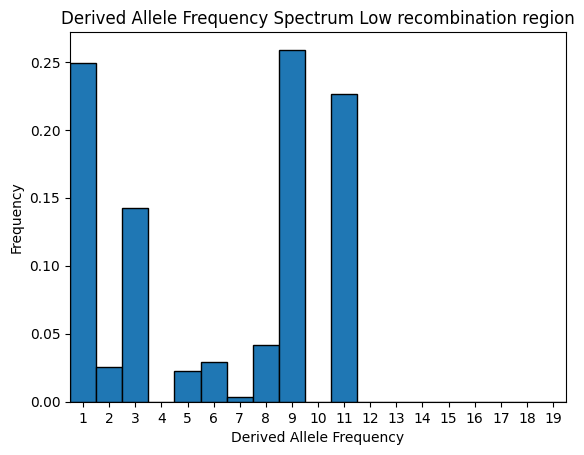

<Figure size 640x480 with 0 Axes>

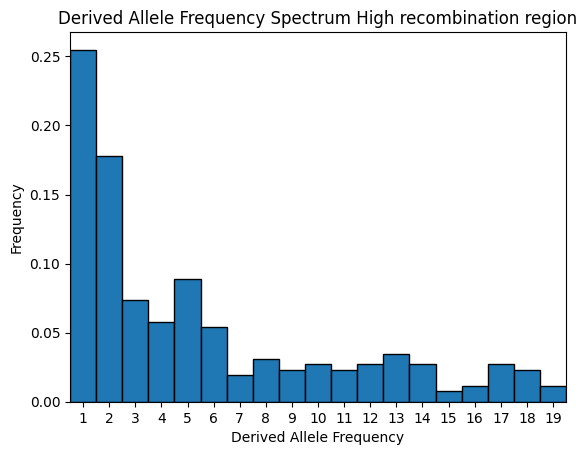

<Figure size 640x480 with 0 Axes>

In [24]:

bins = np.arange(len(lis_train_50k_derived[0]))
#rho=train_target_un_50k[0]
#number_tree_changes=3.597739657143682*train_target_un_50k[0]
# Plotting the histogram-like plot
plt.bar(range(1,20,1), lis_train_50k_derived[0], width=1.0, edgecolor='black') 
plt.title('Derived Allele Frequency Spectrum Low recombination region')
plt.xlabel('Derived Allele Frequency')
plt.ylabel('Frequency')
plt.xticks(range(1,20,1))
plt.margins(x=0)
plt.savefig('./Low_recombination.png')
plt.show()
plt.clf()   
plt.show()



bins = np.arange(len(lis_train_50k_derived[-1]))
#rho=train_target_un_50k[-1]
#number_tree_changes=3.597739657143682*train_target_un_50k[-1]
# Plotting the histogram-like plot
plt.bar(range(1,20,1), lis_train_50k_derived[-1], width=1.0, edgecolor='black') 
plt.title('Derived Allele Frequency Spectrum High recombination region')
plt.xlabel('Derived Allele Frequency')
plt.ylabel('Frequency')
plt.xticks(range(1,20,1))

plt.margins(x=0)
plt.savefig('./High_recombination.png')
plt.show()
plt.clf()   
plt.show()




## Get L-2 norm for minor and derived AFS

In [25]:
lis_train_50k_H_minor= [L_2(i,10) for i in lis_train_50k_minor]
lis_train_50k_H_derived= [L_2(i,19) for i in lis_train_50k_derived]


In [26]:
print('L-2, Low recombination',lis_train_50k_H_derived[0])
print('L-2, High recombination',lis_train_50k_H_derived[-1])

L-2, Low recombination 0.346804374362998
L-2, High recombination 0.06969638839213643


# Correlation between Log-L-2 norm and Rho value

########################### Derived ################################
-0.8951544024229791


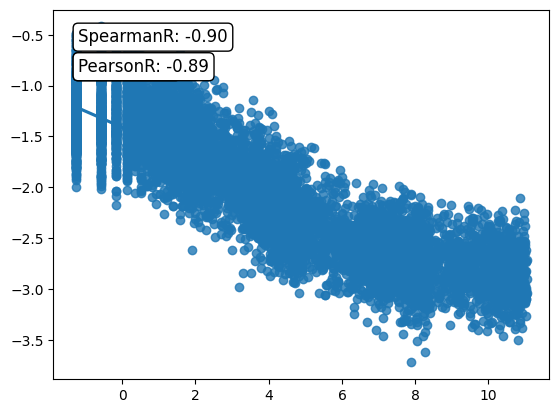

########################### Minor ################################
-0.836708439506539


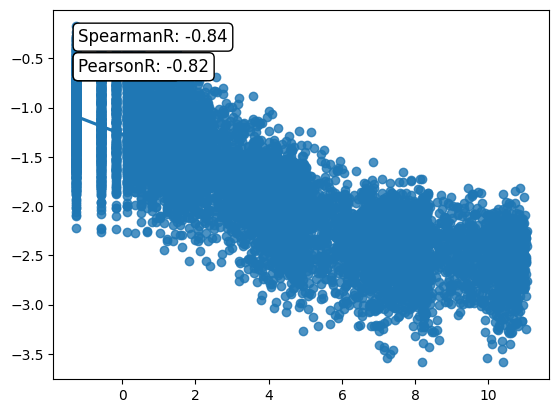

<Figure size 640x480 with 0 Axes>

In [27]:
print('########################### Derived ################################')
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import r2_score
df=pd.DataFrame({'L-2':np.log(lis_train_50k_H_derived),'rho':np.log(train_target_un_50k)})
sns.regplot(x='rho', y='L-2', data=df)
plt.xlabel('log(L-2 Norm derived)')
plt.ylabel('log(rho)')
rho_sp,p=spearmanr(df['L-2'],df['rho'])
r2=r2_score(df['L-2'],df['rho'])
rho_pr,p=pearsonr(df['L-2'],df['rho'])
print(rho_sp)
plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.annotate(f'R2: {r2:.2f}', xy=(0.05, 0.87), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.annotate(f'PearsonR: {rho_pr:.2f}', xy=(0.05, 0.87), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.xlabel('')
plt.ylabel('')
plt.savefig('./L-2 Norm derived.png')
plt.show()
plt.clf()   



print('########################### Minor ################################')
df=pd.DataFrame({'L-2':np.log(lis_train_50k_H_minor),'rho':np.log(train_target_un_50k)})
sns.regplot(x='rho', y='L-2', data=df)

plt.xlabel('log(L-2 Norm Minor)')
plt.ylabel('log(rho)')
rho_sp,p=spearmanr(df['L-2'],df['rho'])
r2=r2_score(df['L-2'],df['rho'])
rho_pr,p=pearsonr(df['L-2'],df['rho'])
print(rho_sp)
plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.annotate(f'R2: {r2:.2f}', xy=(0.05,0.87), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.annotate(f'PearsonR: {rho_pr:.2f}', xy=(0.05, 0.87), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.xlabel('')
plt.ylabel('')
plt.savefig('./L-2 Norm minor.png')
plt.show()
plt.clf()   


# Training Process

50k_100


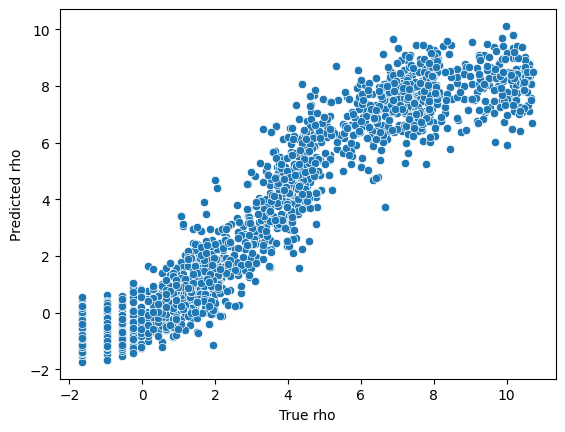

R2 Score: 0.9020407768850937
MSE: 1.2569775635033191
Speramanr: 0.9504297746812205
Pearsonr: 0.9498071017026921
Cross Validation score: [0.9014591  0.90196502 0.89994732 0.90520434 0.89925993]


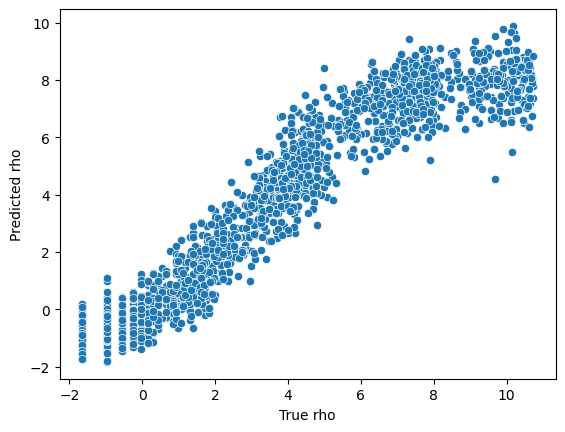

R2 Score: 0.9084296306279955
MSE: 1.1882789910872955
Speramanr: 0.9578169990031193
Pearsonr: 0.9533339148237214
Cross Validation score: [0.90368015 0.91033047 0.90467142 0.90790229 0.90005338]
102.48166871070862
10k


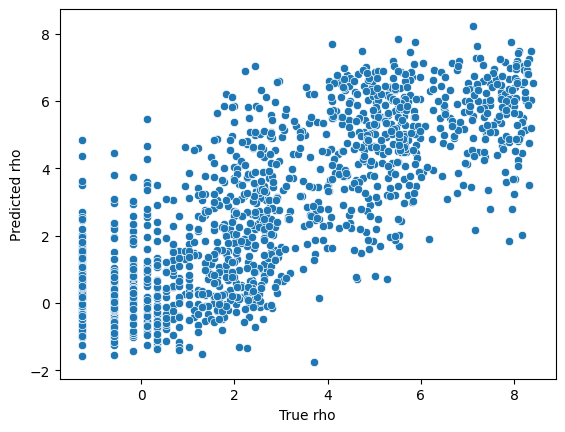

R2 Score: 0.6274501857996932
MSE: 2.98513970602277
Speramanr: 0.7893652061759235
Pearsonr: 0.7955902974489705
Cross Validation score: [0.6246725  0.63624505 0.64461957 0.63447234 0.63100943]


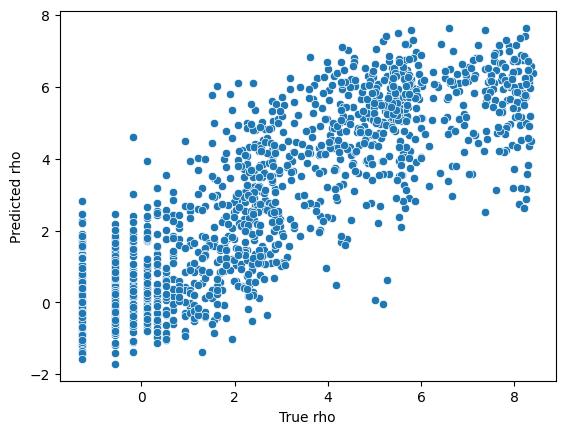

R2 Score: 0.7208279531615104
MSE: 2.3635011092770473
Speramanr: 0.8478607629901943
Pearsonr: 0.8495572829645227
Cross Validation score: [0.73594543 0.71693326 0.73364485 0.72523189 0.71812198]
28.147419929504395
50k


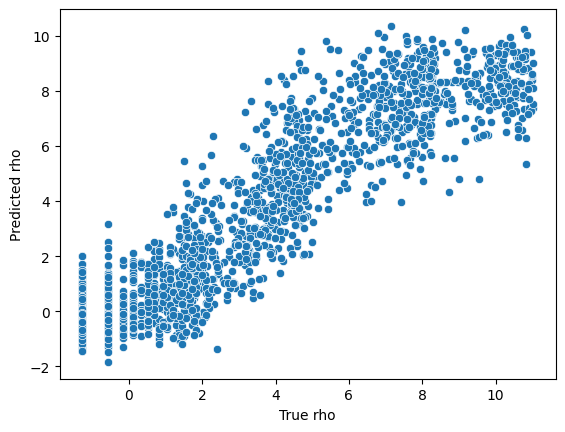

R2 Score: 0.8354204945677094
MSE: 2.1947751289184882
Speramanr: 0.9066666818749433
Pearsonr: 0.914134089305543
Cross Validation score: [0.83918404 0.831126   0.83591668 0.84464611 0.82991808]


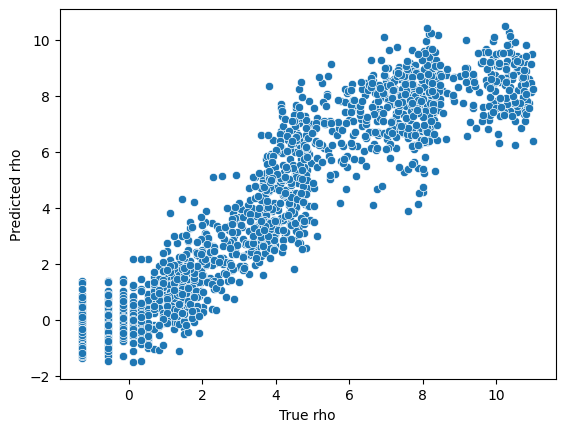

R2 Score: 0.8808094976795868
MSE: 1.5401696441585413
Speramanr: 0.940226610187751
Pearsonr: 0.9388017399032106
Cross Validation score: [0.87647871 0.88298199 0.87679326 0.87504738 0.87160278]
41.54710030555725
100k


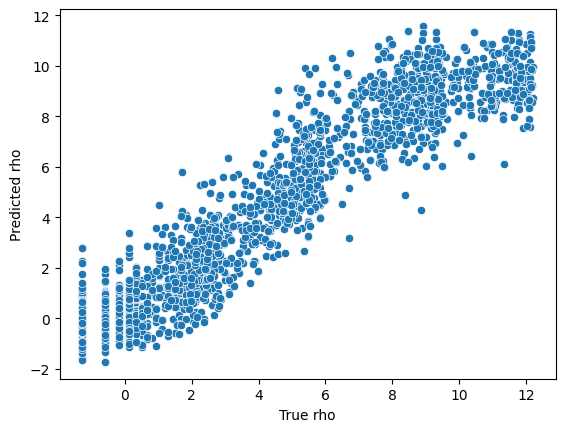

R2 Score: 0.8872143177205019
MSE: 1.8096019446937996
Speramanr: 0.9365192515196802
Pearsonr: 0.9419672592928766
Cross Validation score: [0.87685951 0.87343824 0.87376339 0.8789505  0.87567205]


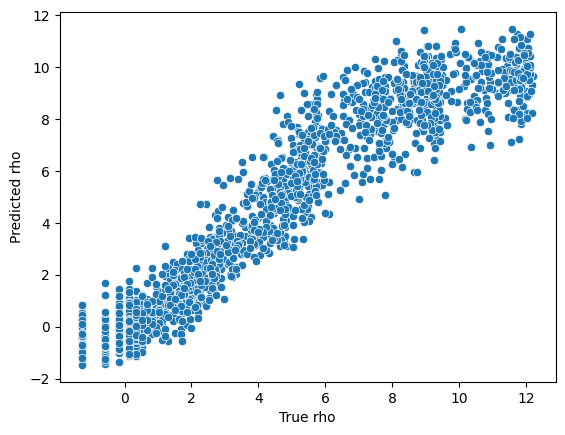

R2 Score: 0.9073084483645011
MSE: 1.4500921872392831
Speramanr: 0.9557533666002308
Pearsonr: 0.9526127900051743
Cross Validation score: [0.90189063 0.90207224 0.90429586 0.90670565 0.90604717]
46.617453813552856
150k


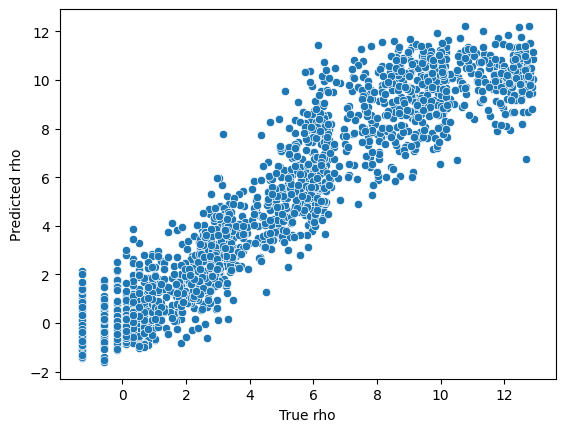

R2 Score: 0.8872457532145599
MSE: 1.9593743715139524
Speramanr: 0.9396867064698953
Pearsonr: 0.942058225535162
Cross Validation score: [0.88509711 0.8895951  0.87768014 0.88762534 0.88465045]


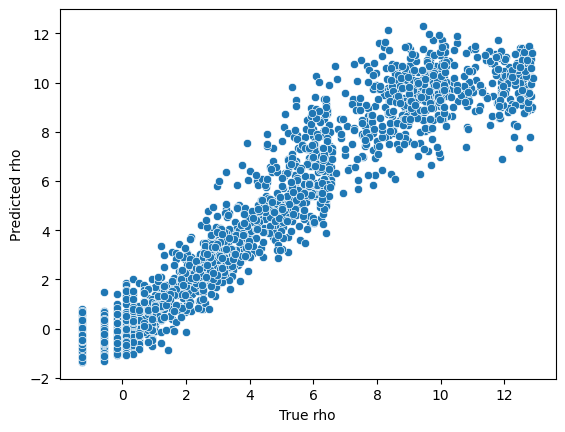

R2 Score: 0.9086779275360459
MSE: 1.5661111531447238
Speramanr: 0.9573845948721857
Pearsonr: 0.9532564378243727
Cross Validation score: [0.9109533  0.91519852 0.90965181 0.90893498 0.91053811]
49.01163363456726
200k


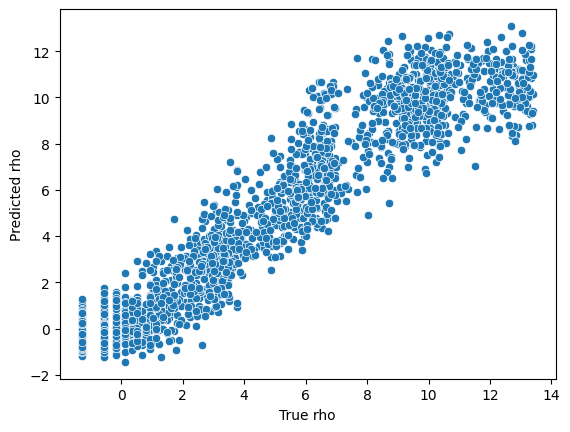

R2 Score: 0.8961801274841439
MSE: 1.8590037160036696
Speramanr: 0.9458950112039639
Pearsonr: 0.9468061276630635
Cross Validation score: [0.89539115 0.89075035 0.895368   0.90523881 0.89196228]


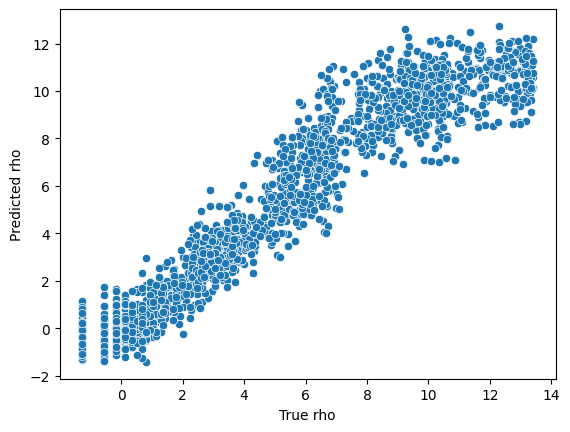

R2 Score: 0.9179340858589853
MSE: 1.479886667835453
Speramanr: 0.9603270250960594
Pearsonr: 0.9581212942604288
Cross Validation score: [0.92004979 0.92430753 0.92204123 0.91526561 0.91161146]
50.542773723602295


<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.model_selection import train_test_split
import time

results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[],'Cross_Validation_score':[]}
sim=['train_50k_100','train_10k','train_50k','train_100k','train_150k','train_200k']
model_dic={'train_50k_100':[],'train_10k':[],'train_50k':[],'train_100k':[],'train_150k':[],'train_200k':[]}

#sim=['train_50k']

#model_dic={'train_50k':[]}

for simulations in sim:
    if simulations=='train_10k':
        print('10k')
        file_rate =location+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_10k_minor
        x_value_derived=lis_train_10k_derived
        y_value=train_target_un_10k
        flag='10k'
    elif simulations=='train_50k':
        print('50k')
        file_rate =location+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_50k_minor
        x_value_derived=lis_train_50k_derived
        y_value=train_target_un_50k
        flag='50k'
    elif simulations=='train_50k_100':
        print('50k_100')
        file_rate =location+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_50k_100_minor
        x_value_derived=lis_train_50k_100_derived
        y_value=train_target_un_50k_100
        flag='50k_100'
    elif simulations=='train_100k':
        print('100k')
        file_rate =location+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_100k_minor
        x_value_derived=lis_train_100k_derived
        y_value=train_target_un_100k
        flag='100k'
    elif simulations=='train_150k':
        print('150k')
        file_rate =location+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_150k_minor
        x_value_derived=lis_train_150k_derived
        y_value=train_target_un_150k
        flag='150k'
    elif simulations=='train_200k':
        print('200k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_200k_minor
        x_value_derived=lis_train_200k_derived
        y_value=train_target_un_200k
        flag='200k'

    X_train, X_test, y_train, y_test = train_test_split(x_value_minor, logit_(y_value), test_size=0.2)
    model_rho_minor,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_minor, logit_(y_value),1,flag+'_rho_minor',results_dic)
    model_dic[simulations]+=[model_rho_minor]
    
    start = time.time()
    X_train, X_test, y_train, y_test = train_test_split(x_value_derived, logit_(y_value), test_size=0.2)
    model_rho_derived,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_derived, logit_(y_value),1,flag+'_rho_derived',results_dic)
    model_dic[simulations]+=[model_rho_derived]
    end = time.time()
    time_=end-start
    print(time_)
    '''
    X_train, X_test, y_train, y_test = train_test_split(x_value_minor, logit_(nTa), test_size=0.2)
    model_c_minor,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_minor, logit_(nTa),0,flag+'_c_minor',results_dic)
    model_dic[simulations]+=[model_c_minor]
    
    X_train, X_test, y_train, y_test = train_test_split(x_value_derived, logit_(nTa), test_size=0.2)
    model_c_derived,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_derived, logit_(nTa),0,flag+'_c_derived',results_dic)
    model_dic[simulations]+=[model_c_derived]
    '''
    result_df= pd.DataFrame(results_dic)


    result_df.to_csv('training_stats.csv', index=False)
    


# Testing on Simulated Dataset

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import time
results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}

sim=['train_50k_100','train_10k','train_50k','train_100k','train_150k','train_200k']
#sim=['train_50k']
#folder= ['./non_eq_tes/','./eq_tes/','./gene_conversion_eq/','./pop_split/']
folder=['./eqtes_50k_100/','./popspliteq_10k/', './popspliteq_50k/', './popspliteq_100k/', './popspliteq_150k/', './popspliteq_200k/', './eqtes_10k/', './eqtes_50k/', './eqtes_100k/', './eqtes_150k/', './eqtes_200k/', './noneqtes_10k/', './noneqtes_50k/', './noneqtes_100k/', './noneqtes_150k/', './noneqtes_200k/', './geneconversioneq_10k/', './geneconversioneq_50k/', './geneconversioneq_100k/', './geneconversioneq_150k/', './geneconversioneq_200k/']
#folder =['./eqtes_50k/','./geneconversioneq_50k/','./noneqtes_50k/','./popspliteq_50k/']
time_=[]
for simulations in sim:
        model_list = model_dic[simulations]
        window_size= simulations.split('_')[1:]
        #for model_index in range(len(model_list)):
        
        
        for fol in folder:
            #print(fol,window_size)
            if fol[2:-1].split('_')[1:]==window_size:
                print(simulations,fol)
                
                ro_minor=[]
                ro_derived=[]
                
                c_minor=[]
                c_derived=[]
                true_rho= np.load(location[:-1]+fol[1:]+fol[2:-1]+'_rate.npy')
                true_c= np.load(location[:-1]+fol[1:]+fol[2:-1]+'_rec_rate.npy')
                
                rho=[]
                c=[]
                for i in range(120):
                        if true_rho[i]>0:
                            ha= np.load(location+fol[1:]+str(i)+'_haps.npy')

                            rho.append(np.log(true_rho[i]))

                            c.append(np.log(true_c[i]))

                            indiv= [100 if len(window_size)==2 else 20][0]
                            #print(indiv)

                            ro_minor.append(predit(ha,model_list[0],0,indiv))
                            start_time= time.time()
                            ro_derived.append(predit(ha,model_list[1],1,indiv))
                            time_.append(time.time()-start_time)

                            #c_minor.append(predit(ha,model_list[2],0,indiv))
                            #c_derived.append(predit(ha,model_list[3],1,indiv))
                        


                dic_minor_ro = {'True_rho': np.array(rho), 'NoDear_rho_minor': [x[0][0] for x in ro_minor]}
                dic_derived_ro= {'True_rho': np.array(rho), 'NoDear_rho_derived': [x[0][0] for x in ro_derived]}

                
                #dic_minor_c = {'True_c': np.array(c), 'NoDear_c_minor': [x[0][0] for x in c_minor]}
                #dic_derived_c= {'True_c': np.array(c), 'NoDear_c_derived': [x[0][0] for x in c_derived]}


                df_minor_ro = pd.DataFrame(dic_minor_ro)
                df_minor_ro.to_csv('NoDear'+fol[2:-1]+'_minor_rho.csv', index=False)
                
                df_derived_ro = pd.DataFrame(dic_derived_ro)
                df_derived_ro.to_csv('NoDear'+fol[2:-1]+'_derived_rho.csv', index=False)
                
                #df_minor_c = pd.DataFrame(dic_minor_c)
                #df_minor_c.to_csv('NoDear'+fol[2:-1]+'_minor_c.csv', index=False)
                
                
                #df_derived_c = pd.DataFrame(dic_derived_c)
                #df_derived_c.to_csv('NoDear'+fol[2:-1]+'_derived_c.csv', index=False)
        





                
                plt.clf()
                results_dic= plotter(df_minor_ro,'True_rho','NoDear_rho_minor',results_dic,fol[2:-1]+'_NoDear_minor_rho',dic_minor_ro)
                results_dic= plotter(df_derived_ro,'True_rho','NoDear_rho_derived',results_dic,fol[2:-1]+'_NoDear_derived_rho',dic_derived_ro)
                
                #results_dic= plotter(df_minor_c,'True_c','NoDear_c_minor',results_dic,fol[2:-1]+'_NoDear_minor_c',dic_minor_c)
                #results_dic= plotter(df_derived_c,'True_c','NoDear_c_derived',results_dic,fol[2:-1]+'_NoDear_derived_c',dic_derived_c)
                
                results_df= pd.DataFrame(results_dic)
                results_df.to_csv('testing_stats.csv', index=False)
print('time',sum(time_))

# Extract pyrho results

<Figure size 640x480 with 0 Axes>

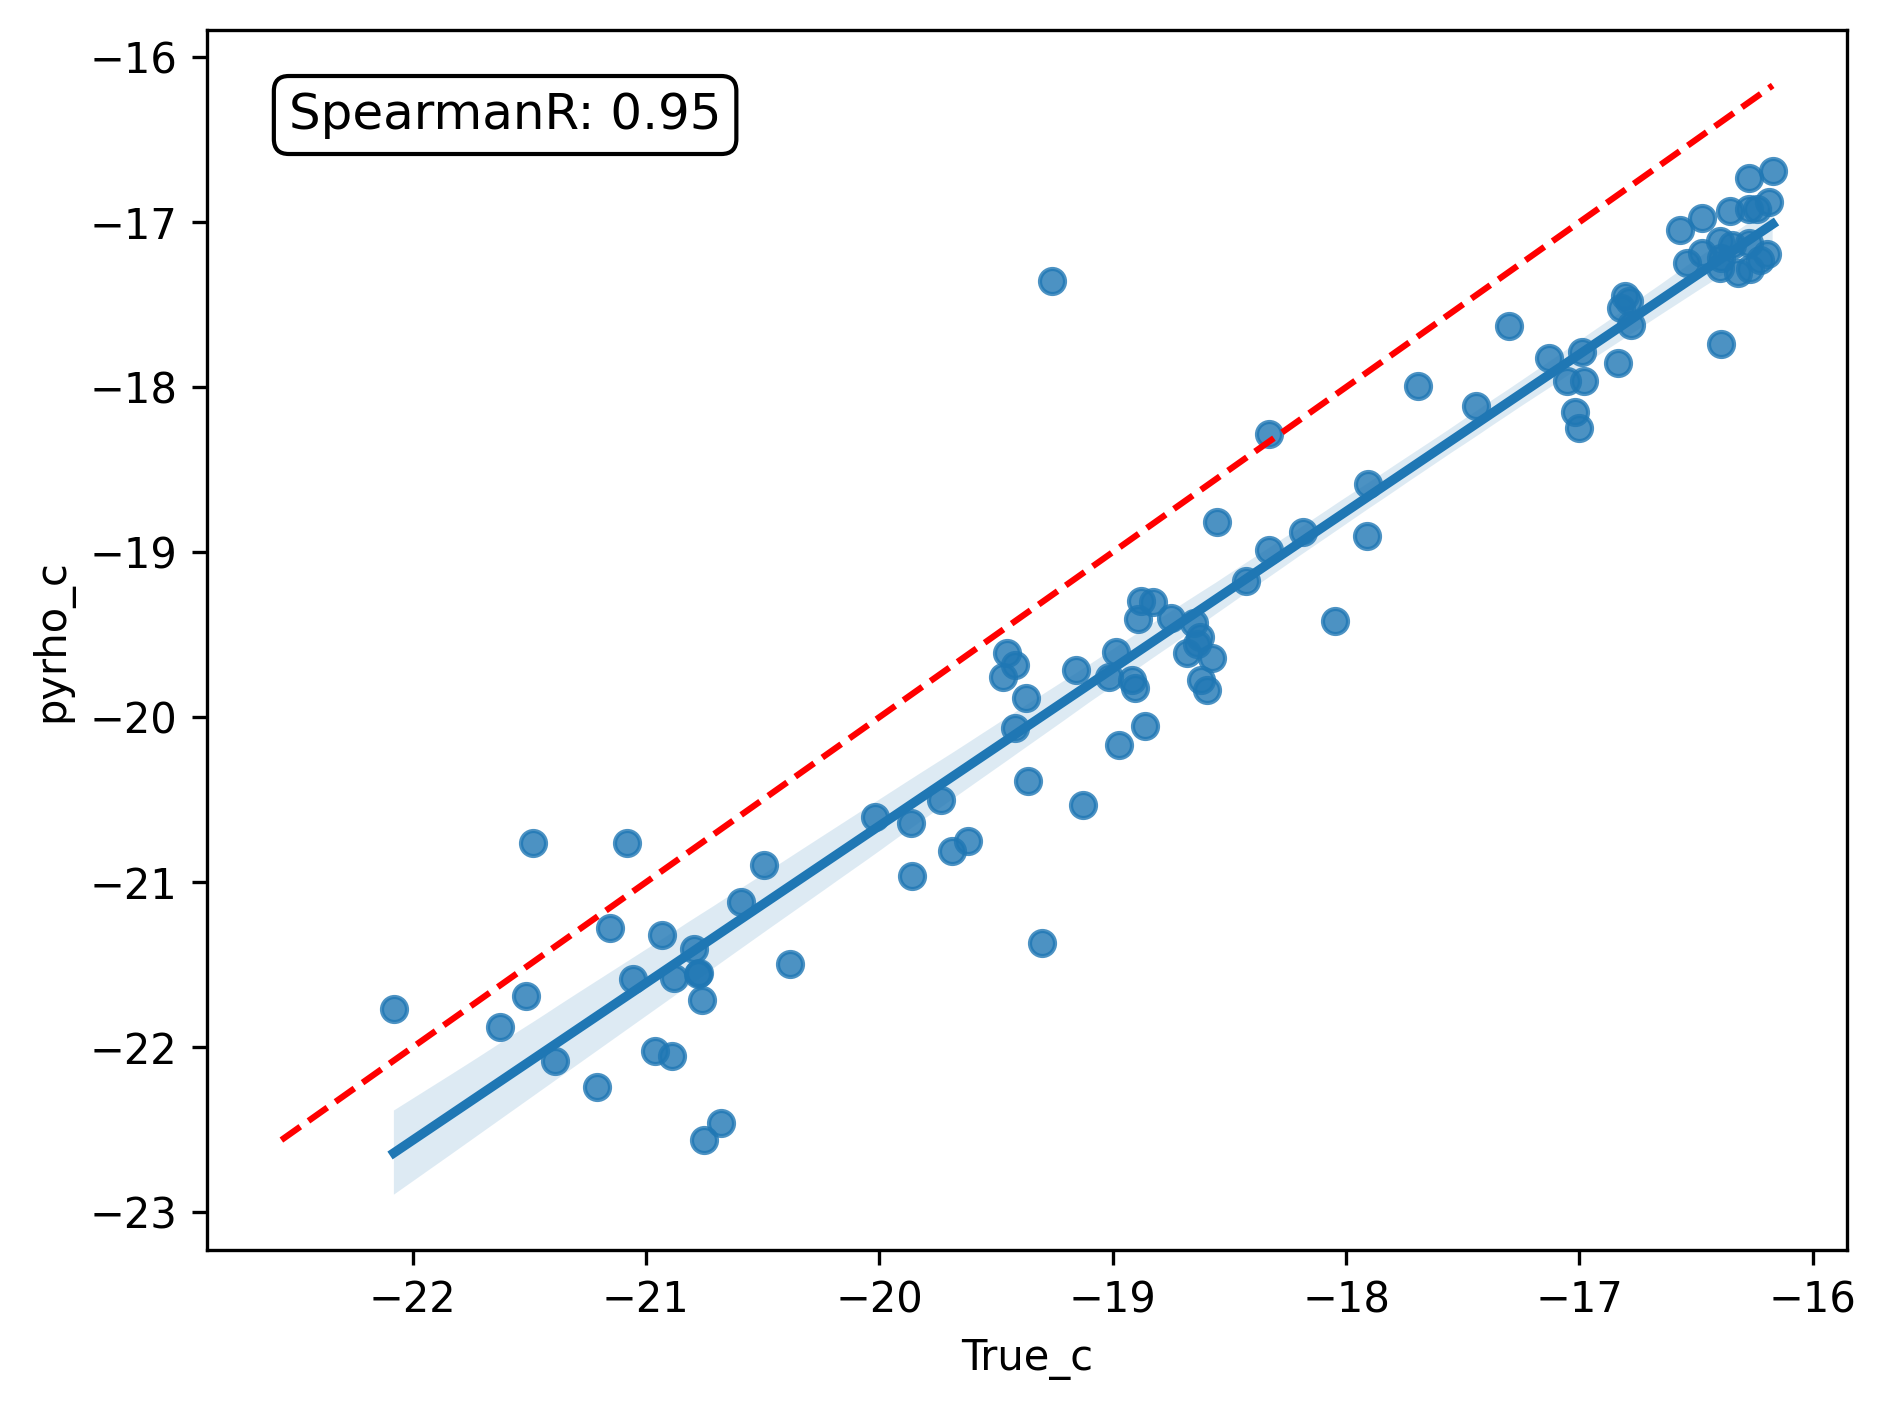

R2 Score: 0.7390503269917831
./noneqtes_50k/
Speramanr: 0.9524247843467283
Pearsonr: 0.9584817535984427
0.7679944746130393
0.7925318465573213


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

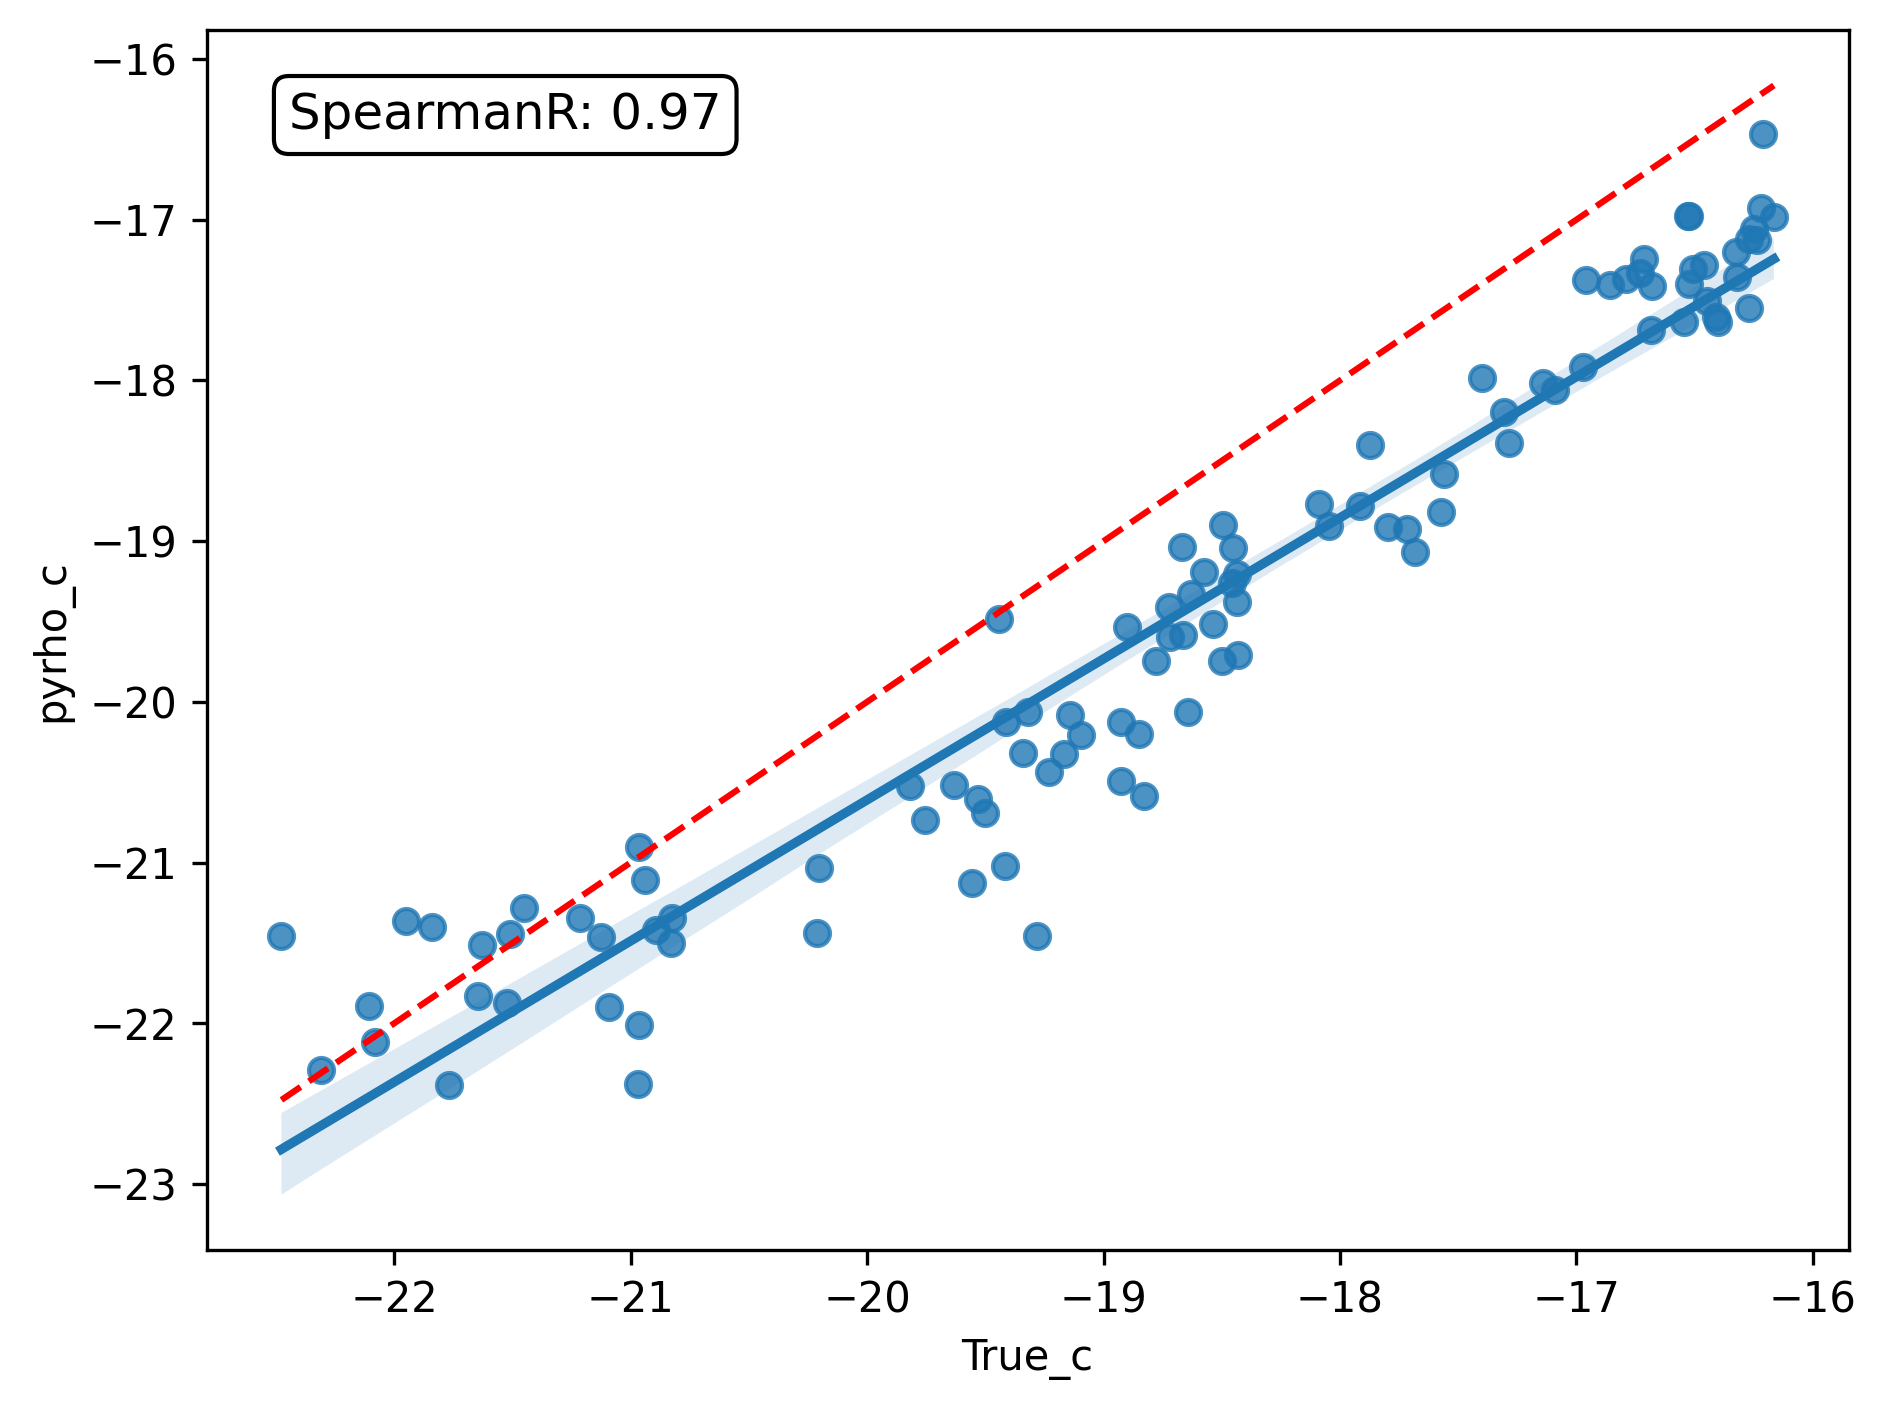

R2 Score: 0.7447677288766215
./eqtes_50k/
Speramanr: 0.9691788002329643
Pearsonr: 0.9623542736512172
0.8405422590049236
0.8206635925591049


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

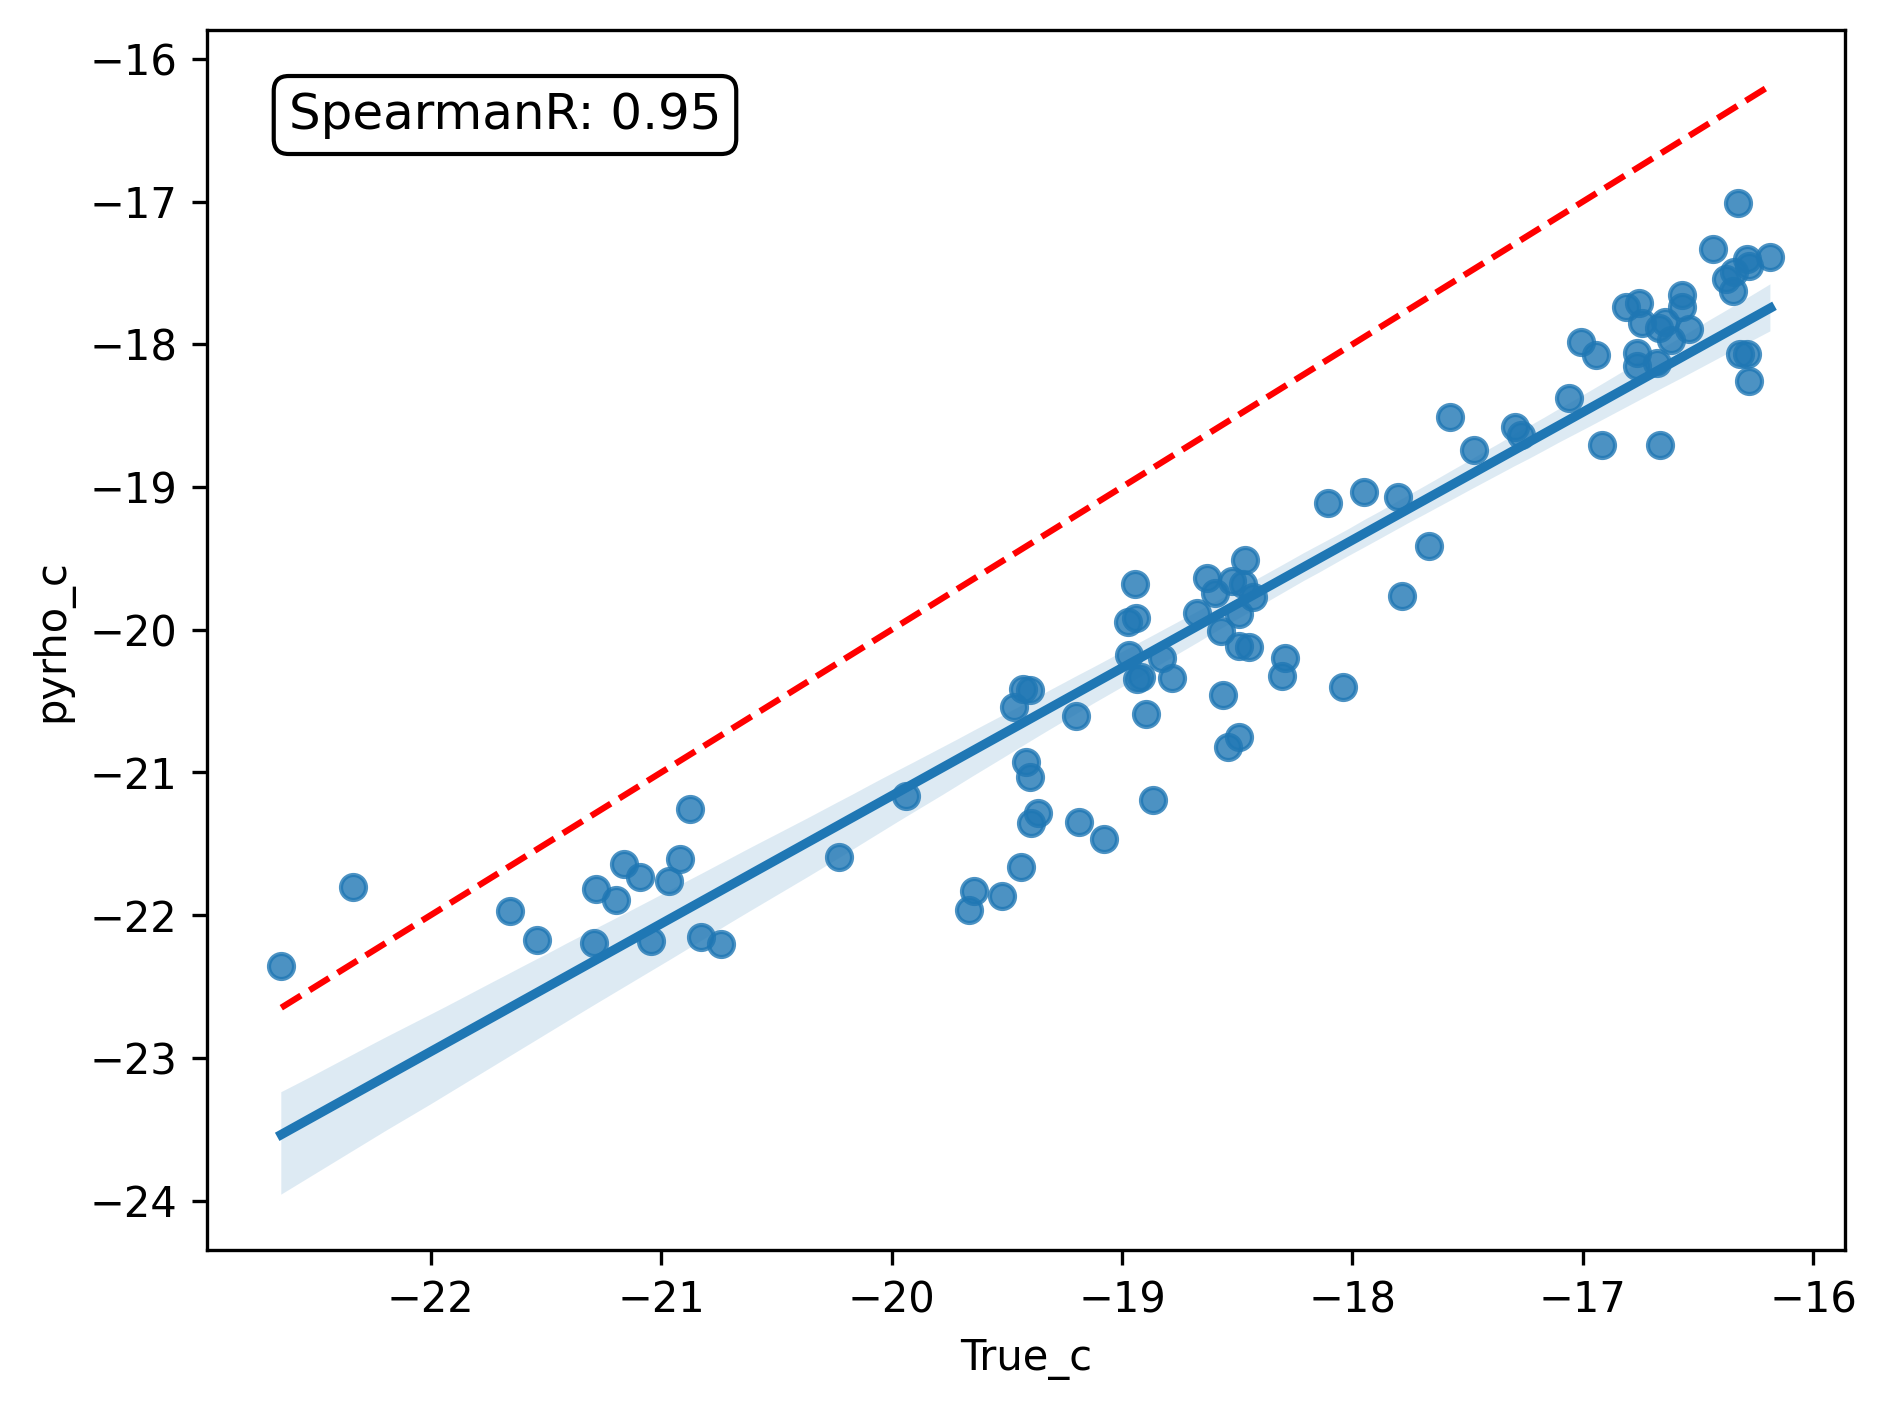

R2 Score: 0.2348241036969917
./geneconversioneq_50k/
Speramanr: 0.9474524076147816
Pearsonr: 0.942491518025915
2.039082371367953
1.3369568710936424


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

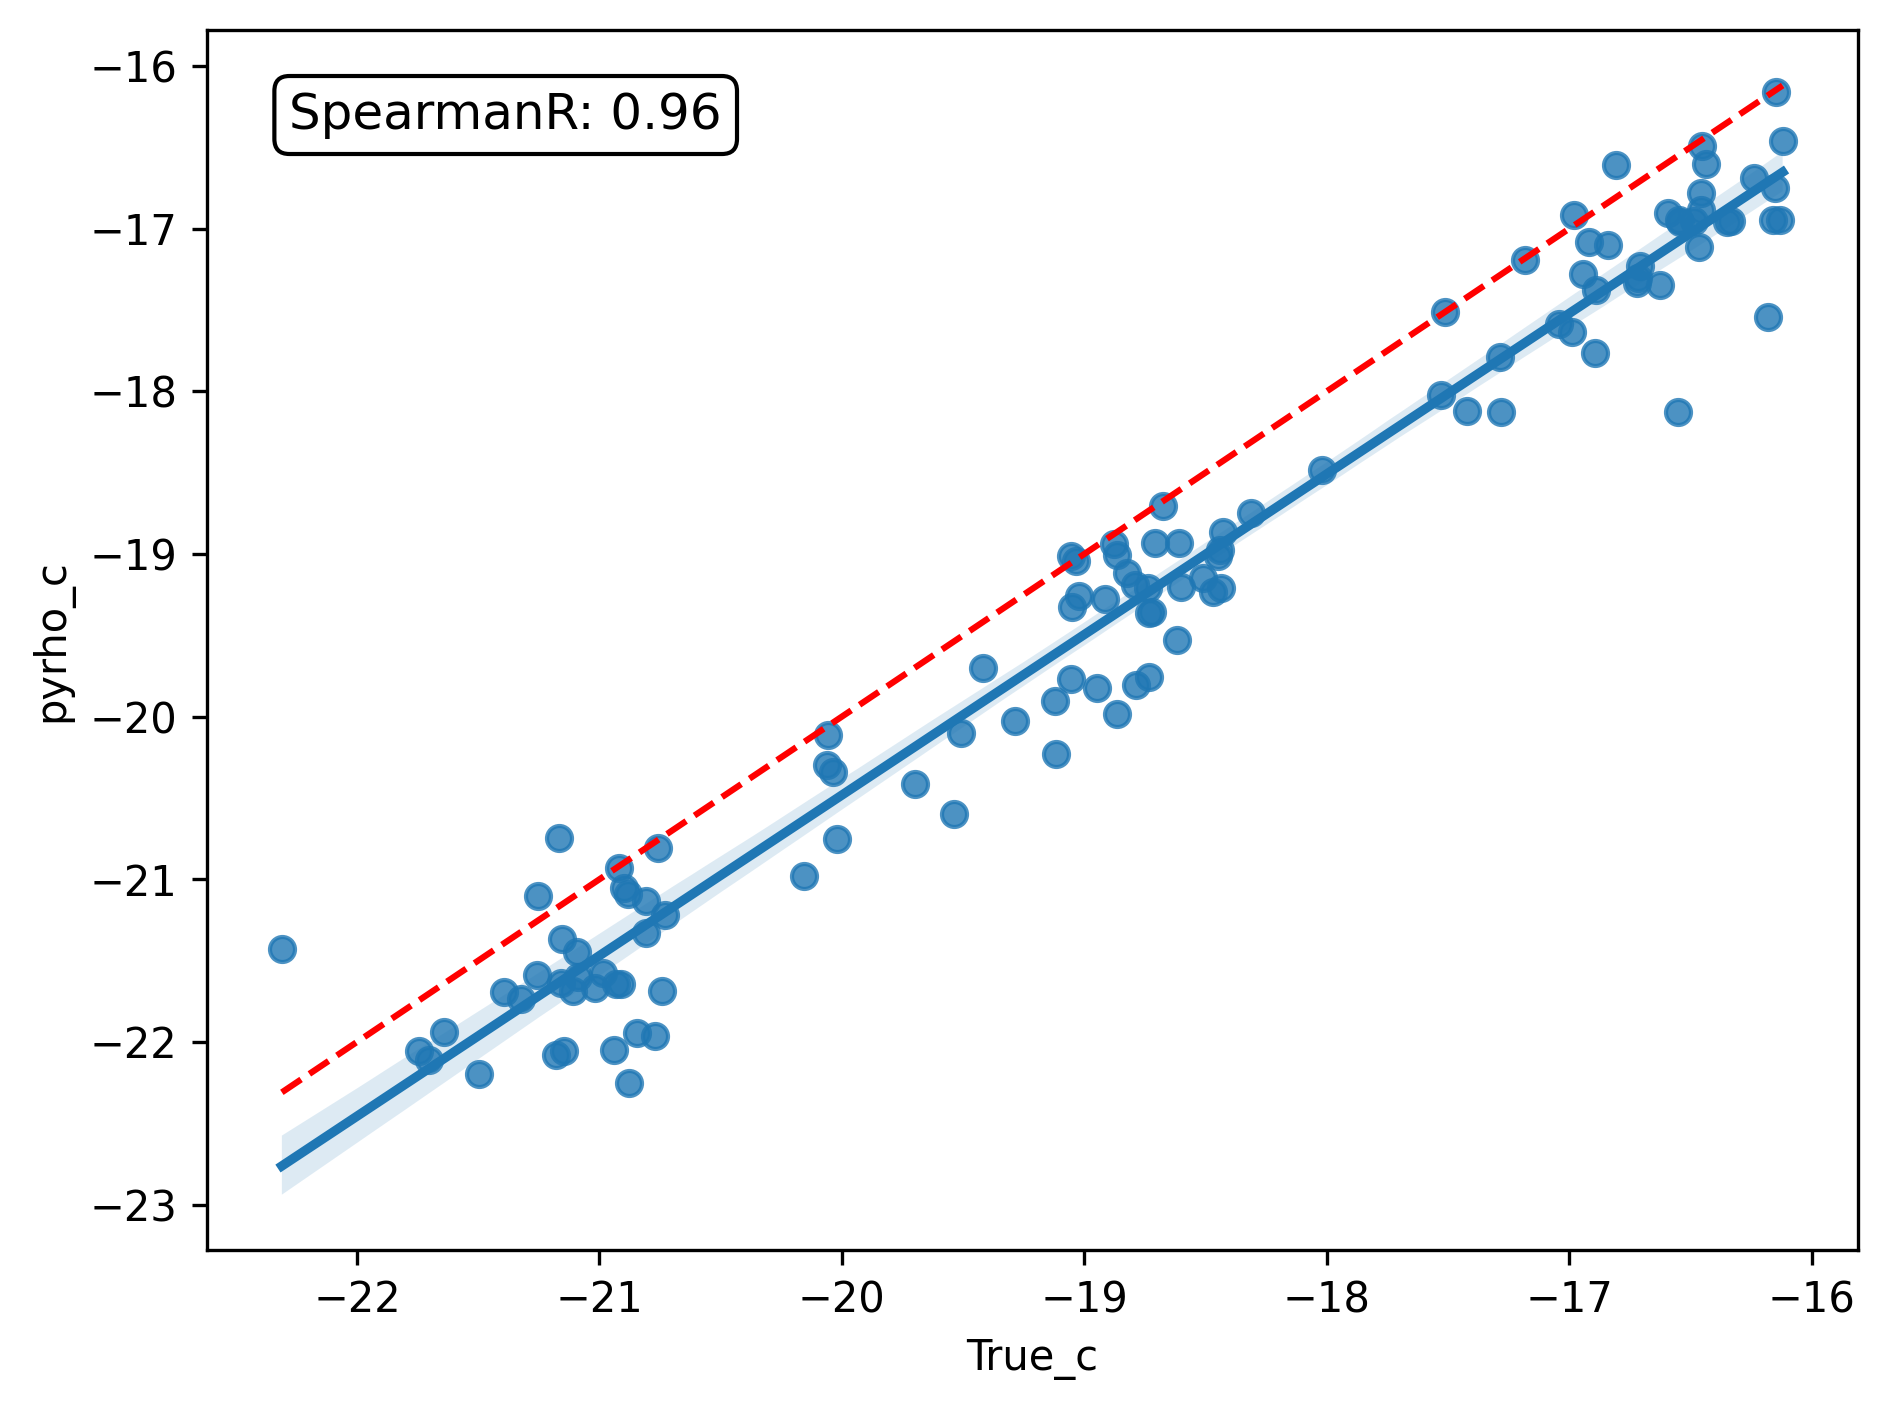

R2 Score: 0.8818493463416373
./popspliteq_50k/
Speramanr: 0.9597611284849291
Pearsonr: 0.978892478312114
0.3872138698361879
0.5286711252037867


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
folder= ['./noneqtes_50k/','./eqtes_50k/','./geneconversioneq_50k/','./popspliteq_50k/']
#folder= ['./eqtes_50k/']

from sklearn.metrics import mean_squared_error,mean_absolute_error
results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}
result_11={}
reject={'noneqtes_50k':[],'eqtes_50k':[],'geneconversioneq_50k':[],'popspliteq_50k':[]}
for fol in folder:
    

    pyc=[]
    true_c=[]
    vae=[]
    
    ha= np.load(location[:-1]+fol[1:]+fol[2:-1]+'_rec_rate.npy')
                
    reje=[]
    for i in range(120):
        try:
            op =open(location[:-1]+fol[1:]+str(i)+'.rmap')
            op_read =op.read().strip()
            op.close()



            
            recom=[]

            li_op= op_read.split('\n')

            upper= li_op[-1].split('\t')[1]
            lower= li_op[0].split('\t')[0]
            for j in li_op:
                v_1 = j.split('\t')
                v_2 = (int(v_1[1])-int(v_1[0]))* float(v_1[2])
                vae.append(int(v_1[1])-int(v_1[0]))
                recom.append(v_2)
                
            avg_1=sum(recom)/(int(upper)-int(lower))   
            if avg_1 > 1e-17:
                true_c.append(ha[i])
                pyc.append(avg_1)

        except:
            reject[fol[2:-1]].append(i)
            continue
        #re.append(sum(recom)/(int(upper)-int(lower)))
        

    dic_c = {'True_c': np.log(np.array(true_c)), 'pyrho_c':  np.log(pyc)}
    #print(dic_c)


    df_c = pd.DataFrame(dic_c)
    df_c.to_csv('pyrho'+fol[2:-1]+'_c.csv', index=False)
                
    





                
    plt.clf()
    results_dic= plotter(df_c,'True_c','pyrho_c',results_dic,fol[2:-1]+'_pyrho_c',dic_c)
    
    results_df.to_csv('pyrho_test_results.csv', index=False)
    

# Running Human Genome (FIN Chr-6) source: 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr6.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz'

In [31]:

oep =open(location+'url_list_fin.txt')
oep_r =oep.read()
oep.close()
url=[]
for ie in oep_r.strip().split('\n'):
    url.append(ie.split(' 	')[0])


urls = []
chromosome_names = []

for ii in url:
    chromosome_names.append(ii.split('chr')[1].split('.')[0])


## Use Pysam to extract genotype from VCF and use NoDEAR to predict rho

6 ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr6.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz
0-50000
50000-100000
100000-150000
150000-200000


[W::bcf_hdr_check_sanity] GL should be declared as Number=G


200000-250000
250000-300000
300000-350000
350000-400000
400000-450000
450000-500000
500000-550000
550000-600000
600000-650000
650000-700000
700000-750000
750000-800000
800000-850000
850000-900000
900000-950000
950000-1000000
1000000-1050000
1050000-1100000
1100000-1150000
1150000-1200000
1200000-1250000
1250000-1300000
1300000-1350000
1350000-1400000
1400000-1450000
1450000-1500000
1500000-1550000
1550000-1600000
1600000-1650000
1650000-1700000
1700000-1750000
1750000-1800000
1800000-1850000
1850000-1900000
1900000-1950000
1950000-2000000
2000000-2050000
2050000-2100000
2100000-2150000
2150000-2200000
2200000-2250000
2250000-2300000
2300000-2350000
2350000-2400000
2400000-2450000
2450000-2500000
2500000-2550000
2550000-2600000
2600000-2650000
2650000-2700000
2700000-2750000
2750000-2800000
2800000-2850000
2850000-2900000
2900000-2950000
2950000-3000000
3000000-3050000
3050000-3100000
3100000-3150000
3150000-3200000
3200000-3250000
3250000-3300000
3300000-3350000
3350000-3400000
3400000

24150000-24200000
24200000-24250000
24250000-24300000
24300000-24350000
24350000-24400000
24400000-24450000
24450000-24500000
24500000-24550000
24550000-24600000
24600000-24650000
24650000-24700000
24700000-24750000
24750000-24800000
24800000-24850000
24850000-24900000
24900000-24950000
24950000-25000000
25000000-25050000
25050000-25100000
25100000-25150000
25150000-25200000
25200000-25250000
25250000-25300000
25300000-25350000
25350000-25400000
25400000-25450000
25450000-25500000
25500000-25550000
25550000-25600000
25600000-25650000
25650000-25700000
25700000-25750000
25750000-25800000
25800000-25850000
25850000-25900000
25900000-25950000
25950000-26000000
26000000-26050000
26050000-26100000
26100000-26150000
26150000-26200000
26200000-26250000
26250000-26300000
26300000-26350000
26350000-26400000
26400000-26450000
26450000-26500000
26500000-26550000
26550000-26600000
26600000-26650000
26650000-26700000
26700000-26750000
26750000-26800000
26800000-26850000
26850000-26900000
26900000-2

47000000-47050000
47050000-47100000
47100000-47150000
47150000-47200000
47200000-47250000
47250000-47300000
47300000-47350000
47350000-47400000
47400000-47450000
47450000-47500000
47500000-47550000
47550000-47600000
47600000-47650000
47650000-47700000
47700000-47750000
47750000-47800000
47800000-47850000
47850000-47900000
47900000-47950000
47950000-48000000
48000000-48050000
48050000-48100000
48100000-48150000
48150000-48200000
48200000-48250000
48250000-48300000
48300000-48350000
48350000-48400000
48400000-48450000
48450000-48500000
48500000-48550000
48550000-48600000
48600000-48650000
48650000-48700000
48700000-48750000
48750000-48800000
48800000-48850000
48850000-48900000
48900000-48950000
48950000-49000000
49000000-49050000
49050000-49100000
49100000-49150000
49150000-49200000
49200000-49250000
49250000-49300000
49300000-49350000
49350000-49400000
49400000-49450000
49450000-49500000
49500000-49550000
49550000-49600000
49600000-49650000
49650000-49700000
49700000-49750000
49750000-4

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


59000000-59050000
59050000-59100000
59100000-59150000
59150000-59200000
59200000-59250000
59250000-59300000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

59300000-59350000
59350000-59400000
59400000-59450000
59450000-59500000
59500000-59550000
59550000-59600000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

59600000-59650000
59650000-59700000
59700000-59750000
59750000-59800000
59800000-59850000
59850000-59900000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


59900000-59950000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


59950000-60000000
60000000-60050000
60050000-60100000
60100000-60150000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


60150000-60200000
60200000-60250000
60250000-60300000
60300000-60350000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


60350000-60400000
60400000-60450000
60450000-60500000
60500000-60550000
60550000-60600000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


60600000-60650000
60650000-60700000
60700000-60750000
60750000-60800000
60800000-60850000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

60850000-60900000
60900000-60950000
60950000-61000000
61000000-61050000
61050000-61100000
61100000-61150000
61150000-61200000
61200000-61250000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

61250000-61300000
61300000-61350000
61350000-61400000
61400000-61450000
61450000-61500000
61500000-61550000
61550000-61600000
61600000-61650000
61650000-61700000
61700000-61750000
61750000-61800000
61800000-61850000
61850000-61900000
61900000-61950000
61950000-62000000
62000000-62050000
62050000-62100000
62100000-62150000
62150000-62200000
62200000-62250000
62250000-62300000
62300000-62350000
62350000-62400000
62400000-62450000
62450000-62500000
62500000-62550000
62550000-62600000
62600000-62650000
62650000-62700000
62700000-62750000
62750000-62800000
62800000-62850000
62850000-62900000
62900000-62950000
62950000-63000000
63000000-63050000
63050000-63100000
63100000-63150000
63150000-63200000
63200000-63250000
63250000-63300000
63300000-63350000
63350000-63400000
63400000-63450000
63450000-63500000
63500000-63550000
63550000-63600000
63600000-63650000
63650000-63700000
63700000-63750000
63750000-63800000
63800000-63850000
63850000-63900000
63900000-63950000
63950000-64000000
64000000-6

84150000-84200000
84200000-84250000
84250000-84300000
84300000-84350000
84350000-84400000
84400000-84450000
84450000-84500000
84500000-84550000
84550000-84600000
84600000-84650000
84650000-84700000
84700000-84750000
84750000-84800000
84800000-84850000
84850000-84900000
84900000-84950000
84950000-85000000
85000000-85050000
85050000-85100000
85100000-85150000
85150000-85200000
85200000-85250000
85250000-85300000
85300000-85350000
85350000-85400000
85400000-85450000
85450000-85500000
85500000-85550000
85550000-85600000
85600000-85650000
85650000-85700000
85700000-85750000
85750000-85800000
85800000-85850000
85850000-85900000
85900000-85950000
85950000-86000000
86000000-86050000
86050000-86100000
86100000-86150000
86150000-86200000
86200000-86250000
86250000-86300000
86300000-86350000
86350000-86400000
86400000-86450000
86450000-86500000
86500000-86550000
86550000-86600000
86600000-86650000
86650000-86700000
86700000-86750000
86750000-86800000
86800000-86850000
86850000-86900000
86900000-8

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


95850000-95900000
95900000-95950000
95950000-96000000
96000000-96050000
96050000-96100000
96100000-96150000
96150000-96200000
96200000-96250000
96250000-96300000
96300000-96350000
96350000-96400000
96400000-96450000
96450000-96500000
96500000-96550000
96550000-96600000
96600000-96650000
96650000-96700000
96700000-96750000
96750000-96800000
96800000-96850000
96850000-96900000
96900000-96950000
96950000-97000000
97000000-97050000
97050000-97100000
97100000-97150000
97150000-97200000
97200000-97250000
97250000-97300000
97300000-97350000
97350000-97400000
97400000-97450000
97450000-97500000
97500000-97550000
97550000-97600000
97600000-97650000
97650000-97700000
97700000-97750000
97750000-97800000
97800000-97850000
97850000-97900000
97900000-97950000
97950000-98000000
98000000-98050000
98050000-98100000
98100000-98150000
98150000-98200000
98200000-98250000
98250000-98300000
98300000-98350000
98350000-98400000
98400000-98450000
98450000-98500000
98500000-98550000
98550000-98600000
98600000-9

116750000-116800000
116800000-116850000
116850000-116900000
116900000-116950000
116950000-117000000
117000000-117050000
117050000-117100000
117100000-117150000
117150000-117200000
117200000-117250000
117250000-117300000
117300000-117350000
117350000-117400000
117400000-117450000
117450000-117500000
117500000-117550000
117550000-117600000
117600000-117650000
117650000-117700000
117700000-117750000
117750000-117800000
117800000-117850000
117850000-117900000
117900000-117950000
117950000-118000000
118000000-118050000
118050000-118100000
118100000-118150000
118150000-118200000
118200000-118250000
118250000-118300000
118300000-118350000
118350000-118400000
118400000-118450000
118450000-118500000
118500000-118550000
118550000-118600000
118600000-118650000
118650000-118700000
118700000-118750000
118750000-118800000
118800000-118850000
118850000-118900000
118900000-118950000
118950000-119000000
119000000-119050000
119050000-119100000
119100000-119150000
119150000-119200000
119200000-119250000


137250000-137300000
137300000-137350000
137350000-137400000
137400000-137450000
137450000-137500000
137500000-137550000
137550000-137600000
137600000-137650000
137650000-137700000
137700000-137750000
137750000-137800000
137800000-137850000
137850000-137900000
137900000-137950000
137950000-138000000
138000000-138050000
138050000-138100000
138100000-138150000
138150000-138200000
138200000-138250000
138250000-138300000
138300000-138350000
138350000-138400000
138400000-138450000
138450000-138500000
138500000-138550000
138550000-138600000
138600000-138650000
138650000-138700000
138700000-138750000
138750000-138800000
138800000-138850000
138850000-138900000
138900000-138950000
138950000-139000000
139000000-139050000
139050000-139100000
139100000-139150000
139150000-139200000
139200000-139250000
139250000-139300000
139300000-139350000
139350000-139400000
139400000-139450000
139450000-139500000
139500000-139550000
139550000-139600000
139600000-139650000
139650000-139700000
139700000-139750000


157750000-157800000
157800000-157850000
157850000-157900000
157900000-157950000
157950000-158000000
158000000-158050000
158050000-158100000
158100000-158150000
158150000-158200000
158200000-158250000
158250000-158300000
158300000-158350000
158350000-158400000
158400000-158450000
158450000-158500000
158500000-158550000
158550000-158600000
158600000-158650000
158650000-158700000
158700000-158750000
158750000-158800000
158800000-158850000
158850000-158900000
158900000-158950000
158950000-159000000
159000000-159050000
159050000-159100000
159100000-159150000
159150000-159200000
159200000-159250000
159250000-159300000
159300000-159350000
159350000-159400000
159400000-159450000
159450000-159500000
159500000-159550000
159550000-159600000
159600000-159650000
159650000-159700000
159700000-159750000
159750000-159800000
159800000-159850000
159850000-159900000
159900000-159950000
159950000-160000000
160000000-160050000
160050000-160100000
160100000-160150000
160150000-160200000
160200000-160250000


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


168050000-168100000
168100000-168150000
168150000-168200000
168200000-168250000
168250000-168300000
168300000-168350000
168350000-168400000
168400000-168450000
168450000-168500000
168500000-168550000
168550000-168600000
168600000-168650000
168650000-168700000
168700000-168750000
168750000-168800000
168800000-168850000
168850000-168900000
168900000-168950000
168950000-169000000
169000000-169050000
169050000-169100000
169100000-169150000
169150000-169200000
169200000-169250000
169250000-169300000
169300000-169350000
169350000-169400000
169400000-169450000
169450000-169500000
169500000-169550000
169550000-169600000
169600000-169650000
169650000-169700000
169700000-169750000
169750000-169800000
169800000-169850000
169850000-169900000
169900000-169950000
169950000-170000000
170000000-170050000
170050000-170100000
170100000-170150000
170150000-170200000
170200000-170250000
170250000-170300000
170300000-170350000
170350000-170400000
{'Interval': ['50000-100000', '100000-150000', '150000-20000

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


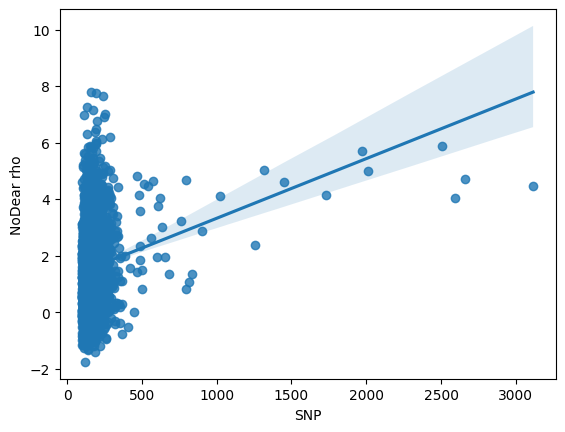

<Figure size 640x480 with 0 Axes>

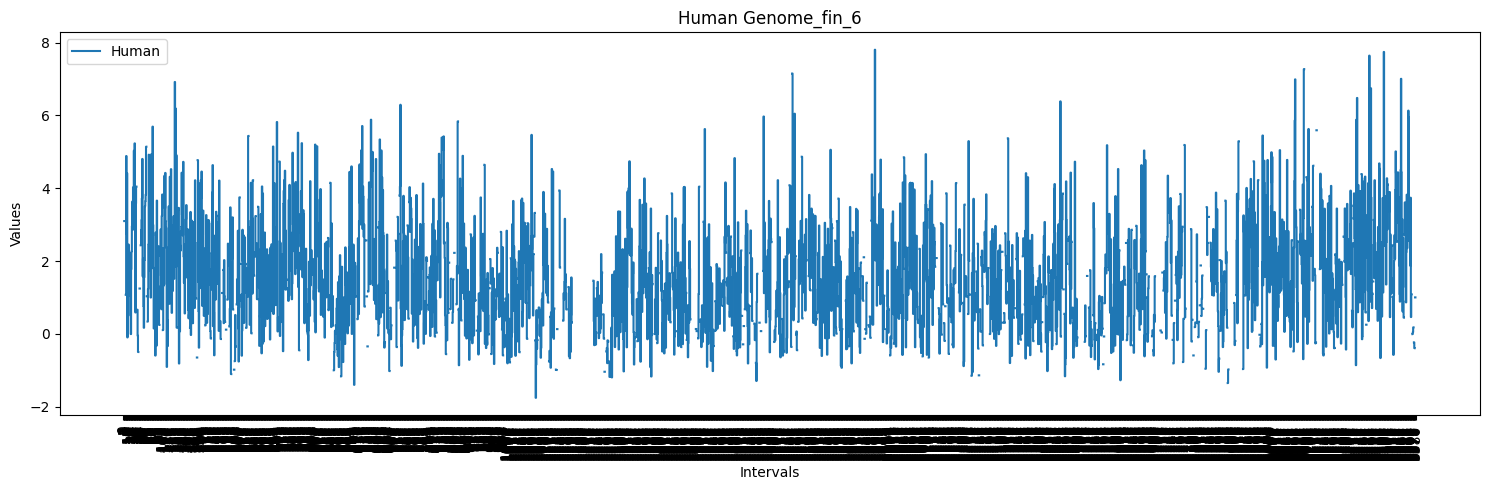

In [32]:
import pysam
import numpy as np
import os
import math
import time

os.environ["PATH"] = "/local/bin/bcftools:" + os.environ["PATH"]
rejected_interval=[]
time_=[]
for ur in url[:1]:
    pred_hu=[]
    chromosome_names= ur.split('chr')[1].split('.')[0]
    print(chromosome_names,ur)
    if ur[-4:]=='.tbi':
        ur=ur[:-4]
    
    count_snp=[]
    interval=[]   
    window_size=50000
    for k in range(0,3408):
        start= str(k*(50000))
        end=str((k+1)*50000)
                  
        print(str(k*(50000))+'-'+str((k+1)*50000))
        #print('tabix -h  	'+ur+' '+chromosome_names+':'+start+'-'+end+' > /N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_'+str(k*(50000))+'_'+str((k+1)*50000)+'.vcf')
        #os.system('tabix -h  	'+ur+' '+chromosome_names+':'+start+'-'+end+' > /N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_'+str(k*(50000))+'_'+str((k+1)*50000)+'.vcf')
 


        file_to_open= location+'human_genome_1/output_'+start+'_'+end+'.vcf'
        #print(file_to_open)
        try:
            vcf_file = pysam.VariantFile(file_to_open)

            # Lists to store data
            data = []


            for record in vcf_file:
                        basic_info = [record.chrom, record.pos, record.ref]
                        genotypes = []
                        for sample in record.samples:
                            genotype = record.samples[sample]['GT']

                            genotype_str = [int(allele) if allele is not None else '.' for allele in genotype]

                            genotypes+=genotype_str




                        data.append(genotypes)


            start_time= time.time()
            genotype_array = np.array(data)

            predec ,SNP= predit(genotype_array,model_dic['train_50k'][0],0,20)
            time_.append(time.time()-start_time)
            #print(SNP)
            ## Filtering for SNP
            if SNP>100:
                pred_hu.append(predec[0])
                count_snp.append(SNP)
                interval.append(str(start)+'-'+str(end))
            else:
                pred_hu.append(None)
                count_snp.append(SNP)
                interval.append(str(start)+'-'+str(end))
                rejected_interval.append(k)
            start= end
            end = str(int(end)+ window_size)
        except:
            start= end
            end = str(int(end)+ window_size)
            


    dic= {'Interval':interval, 'NoDear rho': pred_hu,'SNP':count_snp}
    print(dic)
    pd.DataFrame(dic).to_csv('Human_genome_FIN_6_50k.csv',index=False)


    sns.regplot(x='SNP', y='NoDear rho', data=pd.DataFrame(dic))
    plt.savefig('Human_genome_FIN_6_50k_SNP_rho.jpg')
    plt.show()
    plt.clf()


    file_= pd.read_csv('Human_genome_FIN_6_50k.csv')

    interval,another_y_set, SNP_=file_['Interval'], file_['NoDear rho'],file_['SNP']
    another_y_set= 1*((another_y_set))

    y_values2 = np.divide(another_y_set, 1)


    plt.figure(figsize=(15, 5))

    #lt.step(range(len(interval_list[:110])), y_values1[:110], where='mid', label='19')


    plt.step(range(len(y_values2)), y_values2, where='mid', label='Human')



    plt.xticks(range(len(y_values2)), range(len(y_values2)), rotation=90)

    plt.xlabel('Intervals')
    plt.ylabel('Values')
    plt.title('Human Genome_fin_6')
    plt.legend()  
    plt.tight_layout()
    plt.savefig('Human_genome_FIN_6_50k.jpg')
    plt.show()


# Plot the Landscape

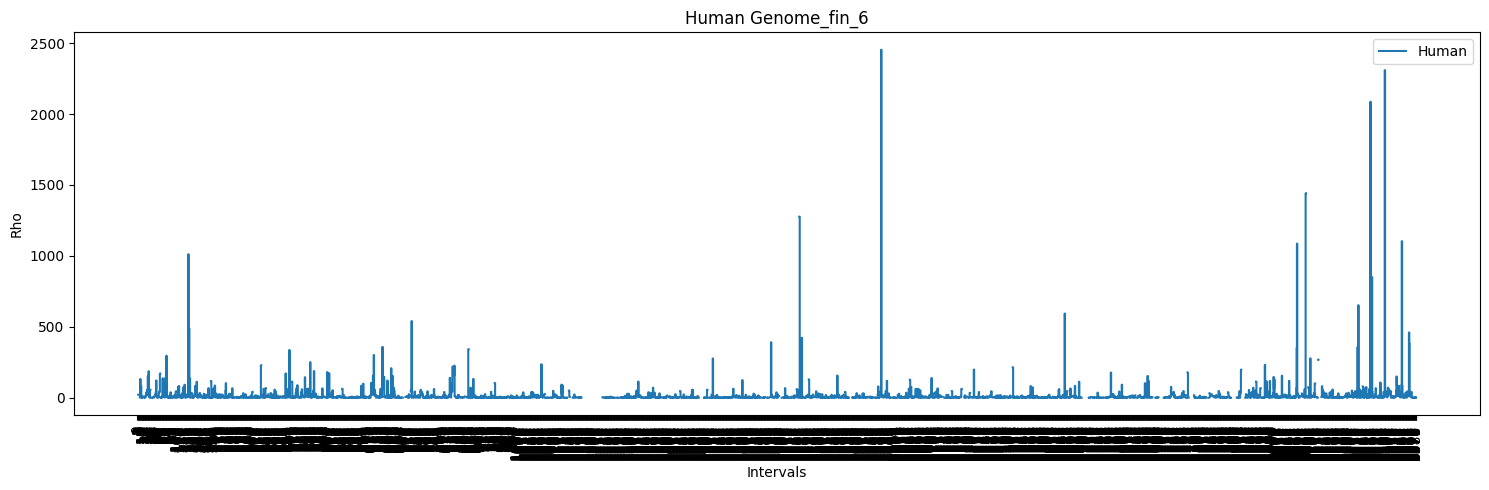

In [44]:
file_= pd.read_csv('./Human_genome_FIN_6_50k.csv')
file_
interval,another_y_set, SNP_=file_['Interval'], file_['NoDear rho'],file_['SNP']
another_y_set= 1*((another_y_set))
y_values2 = np.divide(another_y_set, 1)


plt.figure(figsize=(15, 5))

   

plt.step(range(len(y_values2)), np.exp(y_values2), where='mid', label='Human')


plt.xticks(range(len(y_values2)), range(len(y_values2)), rotation=90)

plt.xlabel('Intervals')
plt.ylabel('Rho')
plt.title('Human Genome_fin_6')
plt.legend()  
plt.tight_layout()
plt.savefig('Human_genome_FIN_6_50k.jpg')
plt.show()

In [45]:
pd.DataFrame(np.exp(y_values2)).dropna().describe()

,NoDear rho
count,2602.000000
mean,21.242324
std,103.253100
min,0.172201
25%,1.555130
50%,4.145742
75%,12.794419
max,2453.117015


# Extract pyrho C values

In [57]:
re={'Interval':[],'pyrho C':[]}
snp=[]
vae=[]
reject=[]
for i in range(3408):

        file_name= 'output_'+str(i*(50000))+'_'+str((i+1)*50000)+'.rmap'
        try:
            
            op =open(location+'human_genome_1/results/'+file_name)
            op_read =op.read().strip()
            op.close()



            #snp.append(ha[i])
            recom=[]
            v_3=[]
            li_op= op_read.split('\n')

            upper= li_op[-1].split('\t')[1]
            lower= li_op[0].split('\t')[0]
            for j in li_op:
                v_1 = j.split('\t')
                v_2 = (int(v_1[1])-int(v_1[0]))* float(v_1[2])
                v_3.append(float(v_1[2]))
                #v_2 = float(v_1[2])
                vae.append(int(v_1[1])-int(v_1[0]))
                recom.append(v_2)
                
            # Filter
            if sum(recom)/(int(upper)-int(lower))> 10e-12 and sum(recom)/(int(upper)-int(lower))<10e-7:
                #The filter to check if the window is variable
                #if (max(v_3)-min(v_3))/max(v_3) >0.8:
                    re['pyrho C']+=[sum(recom)/(int(upper)-int(lower))]
                    re['Interval']+=[str(i*(50000))+'-'+str((i+1)*50000)]

        except:
            reject.append(str(i*(50000))+'_'+str((i+1)*50000))
            continue
    #re.append(sum(recom)/(int(upper)-int(lower)))
    

In [58]:
pd.DataFrame(re['pyrho C'],columns=['pyrho C']).describe()

,pyrho C
count,3.087000e+03
mean,2.873165e-09
std,5.876545e-09
min,4.638974e-11
25%,6.410322e-10
50%,1.584572e-09
75%,3.463090e-09
max,1.510503e-07


In [59]:
re_df=pd.DataFrame(re)

In [60]:
merged_df = pd.merge(file_, re_df, on=re_df.columns.intersection(file_.columns).tolist()
)

In [61]:
merged_df = merged_df.dropna()
merged_df

,Interval,NoDear rho,SNP,pyrho C
0,200000-250000,3.097211,199,2.032993e-08
4,400000-450000,1.070108,179,4.153685e-09
5,450000-500000,4.884345,231,9.856029e-09
6,500000-550000,2.743170,145,3.676068e-09
7,550000-600000,4.408397,135,2.815669e-09
...,...,...,...,...
3080,170000000-170050000,0.045354,103,1.259182e-09
3081,170050000-170100000,0.177202,130,1.365814e-09
3083,170150000-170200000,-0.234634,157,8.559445e-10
3084,170200000-170250000,-0.395802,206,2.506266e-09


In [62]:
merged_df['pyrho C'] = np.log(merged_df['pyrho C'])
merged_df['SNP'] = np.log(merged_df['SNP'])

# Plot the correlation

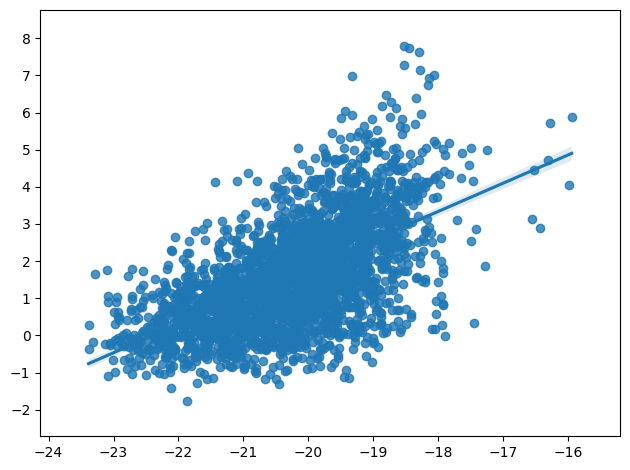

0.5938631517664716

<Figure size 640x480 with 0 Axes>

In [63]:
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import r2_score

rho_sp,p=spearmanr(merged_df['pyrho C'],merged_df['NoDear rho'])
rho_sp

sns.regplot(x='pyrho C', y='NoDear rho', data=merged_df)

#plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(-29, -14,1))
plt.yticks(range(-2, 11,1))
plt.margins(x=0.1)
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig('./Human_genome_NoDear_pyrho.jpg')
plt.show()
plt.clf()

rho_sp

In [64]:
rho_sp,p=pearsonr(merged_df['pyrho C'],merged_df['NoDear rho'])
rho_sp

0.5891686002731358

# ReLERNN


<Figure size 640x480 with 0 Axes>

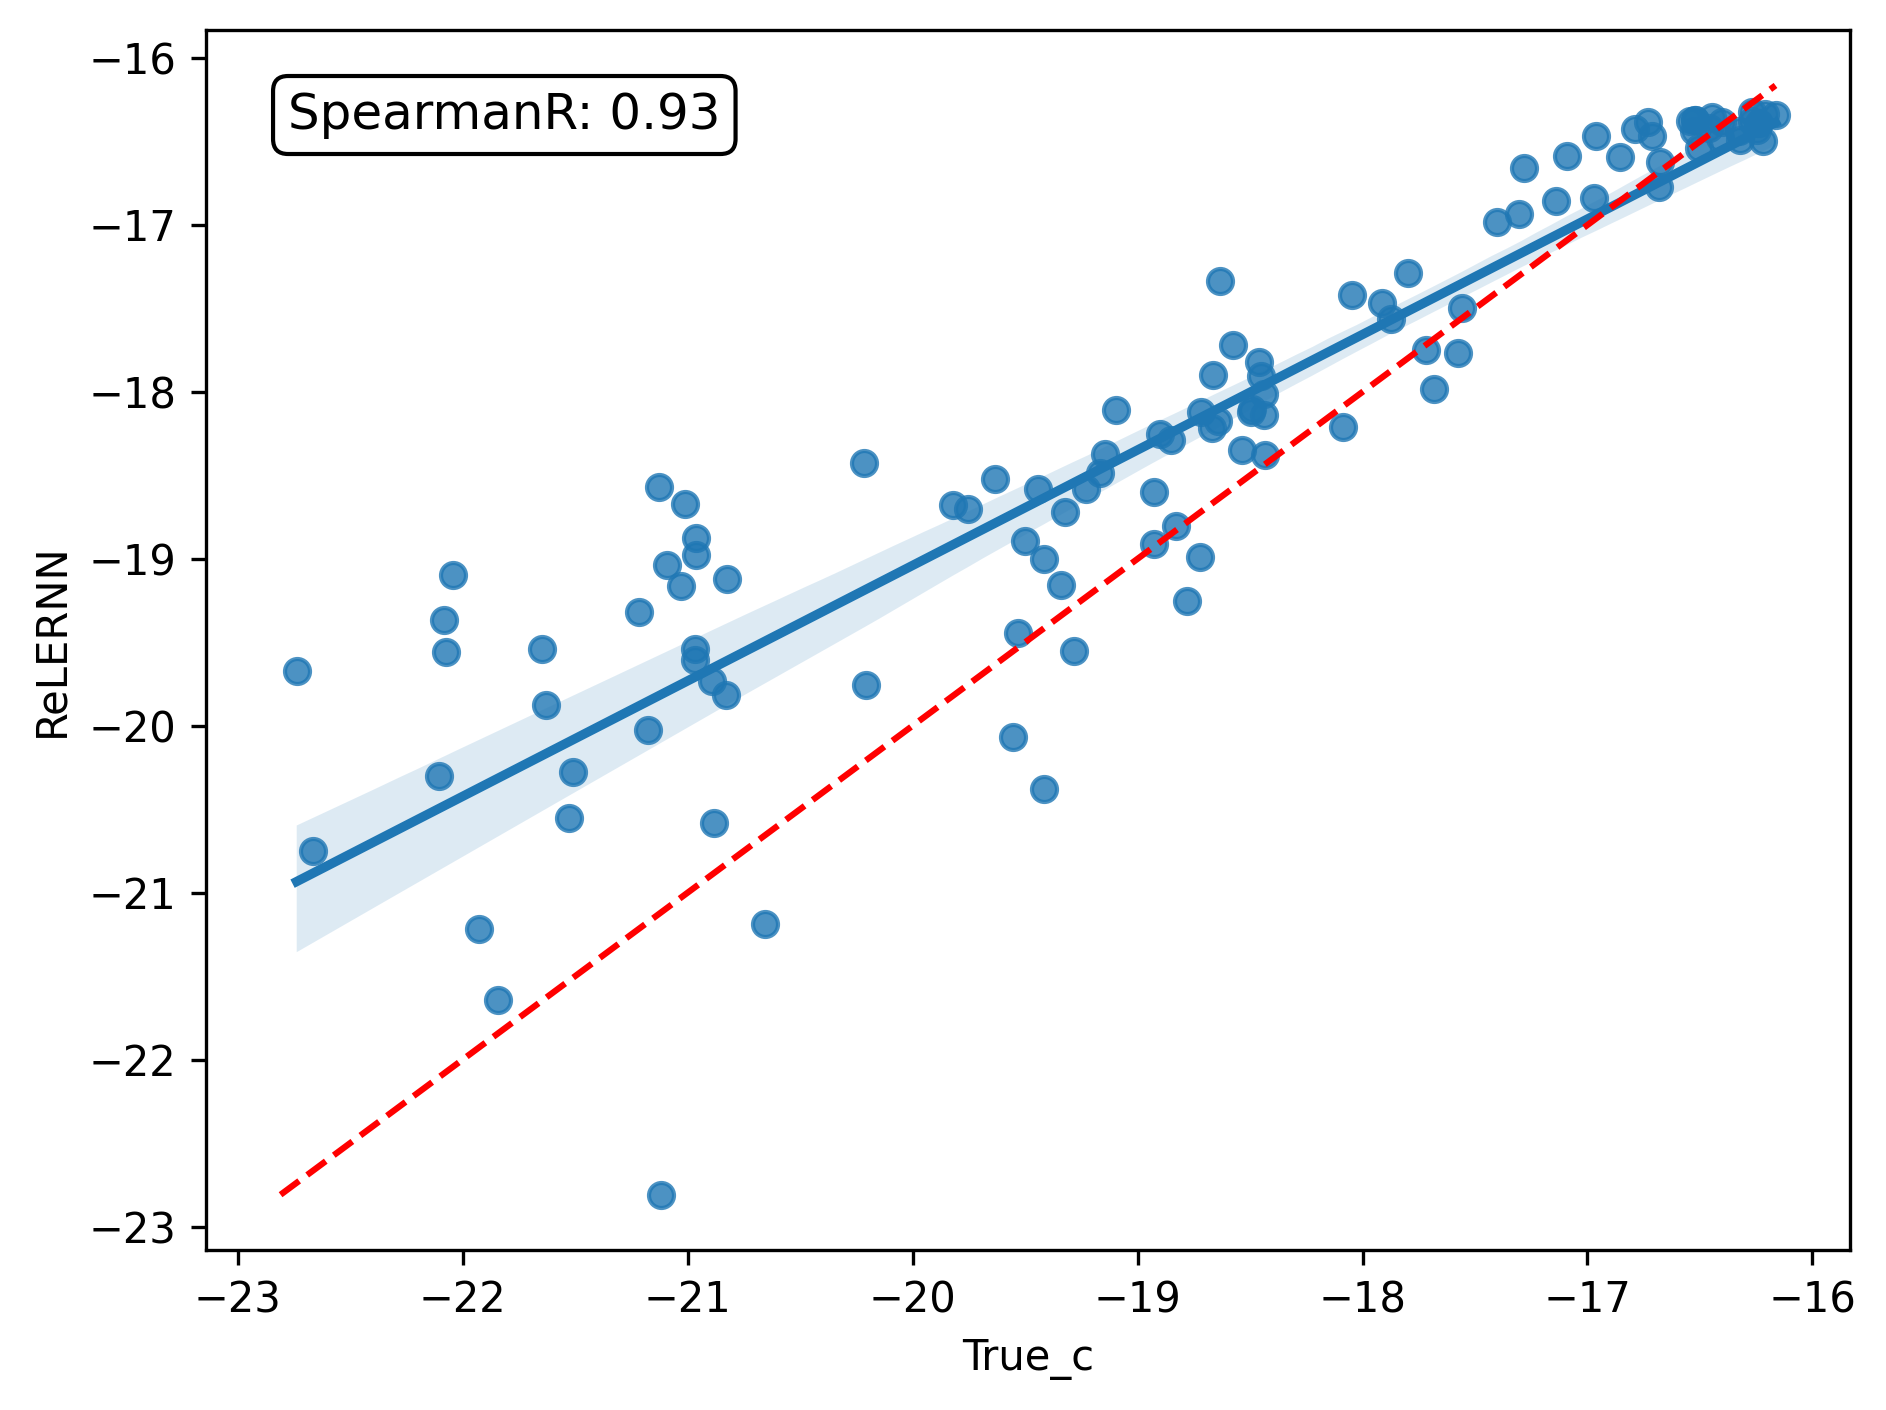

R2 Score: 0.6868288843857246
./popspliteq_50k/
Speramanr: 0.9343345284978154
Pearsonr: 0.9003607950448591
1.0877733156641847
0.7367113143132947


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [65]:
import pandas as pd

results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}
result_11={}
folder={'eqtes_50k':[]}
er=[]
true=np.load('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/eqtes_50k/eqtes_50k_rec_rate.npy')
#df=pd.read_csv('/N/u/samishr/Quartz/Recombination_landscape/NoDeareqtes_50k_derived_rho.csv')
#true=df['NoDear_rho_derived']

relernn_c=[]
true_c=[]

for er4 in range(120):
    value=float(open('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/ReLERNN-master/examples/test_3/results/'+str(er4)+'.PREDICT.txt').read().split('\t')[-1].split('\n')[0])
    if value>0:
        true_c.append(true[er4])
        relernn_c.append(value)
            
dic_c = {'True_c': np.log(np.array(true_c)), 'ReLERNN':  np.log(np.array(relernn_c))}
 

df_c = pd.DataFrame(dic_c)

plt.clf()
results_dic= plotter(df_c,'True_c','ReLERNN',results_dic,'relernn_True_c',dic_c)
results_df =pd.DataFrame(results_dic)
results_df.to_csv('./relernn_test_results.csv', index=False)
